This notebook implements a <b>baseline evaluation</b> for question-answering models on the SQuAD (Stanford Question Answering Dataset) 2.0 dataset without any adversarial attacks.<br /><br />

The main purpose of this notebook is to establish a baseline performance for various question-answering models on the SQuAD dataset. It evaluates the models' performance using metrics such as exact match, F1 score, BLEU score, and grammatical error count. The script is designed to be part of a larger evaluation framework that could include adversarial attacks, although the attack part is not implemented in this code.<br /><br />

The notebook processes the entire SQuAD dataset, evaluates multiple models, and generates comprehensive summaries and visualizations of their performance. This baseline can then be used as a reference point for comparing the models' performance under potential adversarial conditions or other modifications to the dataset.<br /><br />

Key features of this baseline evaluation include:
<ul>
    <li>Evaluation of multiple state-of-the-art question-answering models</li>
    <li>Calculation of various performance metrics</li>
    <li>Generation of detailed summaries and visualizations</li>
    <li>Preparation for potential comparison with adversarial attack scenarios</li>
</ul>

This baseline evaluation provides a thorough understanding of how these models perform on the original SQuAD dataset, serving as a foundation for further research into model robustness and performance under various conditions.

### Loading libraries

Imports necessary libraries for natural language processing, machine learning, data manipulation, and visualization.

In [1]:
import json
import random
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os
from IPython.display import display, Image

In [2]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ferhatsarikaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### BaselineEvaluator class
Initializes a question-answering model and tokenizer.<br />
Implements methods for getting answers, calculating F1 and BLEU scores, and counting grammatical errors.<br />
Evaluates the baseline performance of the model on the dataset.

In [4]:
class BaselineEvaluator:
    def __init__(self, model_name):
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def get_answer(self, question, context):
        inputs = self.tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", max_length=512, truncation=True)
        input_ids = inputs["input_ids"].tolist()[0]
        outputs = self.model(**inputs)
        
        answer_start = torch.argmax(outputs.start_logits)
        answer_end = torch.argmax(outputs.end_logits) + 1
        answer = self.tokenizer.convert_tokens_to_string(self.tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
        return answer

    def calculate_f1_score(self, prediction, ground_truth):
        prediction_tokens = word_tokenize(prediction.lower())
        ground_truth_tokens = word_tokenize(ground_truth.lower())

        common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
        num_same = sum(common.values())

        if num_same == 0:
            return 0

        precision = 1.0 * num_same / len(prediction_tokens)
        recall = 1.0 * num_same / len(ground_truth_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        return f1
    
    def calculate_bleu_score(self, prediction, ground_truth):
        return sentence_bleu([word_tokenize(ground_truth.lower())], word_tokenize(prediction.lower()))

    def count_grammatical_errors(self, text):
        doc = nlp(text)
        return len([token for token in doc if token.dep_ == 'ROOT']) - 1

    def evaluate_baseline(self, data):
        results = []
        for article in tqdm(data, desc="Evaluating Baseline"):
            for paragraph in article['paragraphs']:
                context = paragraph['context']
                for qa in paragraph['qas']:
                    question = qa['question']
                    if qa['answers']:
                        ground_truth = qa['answers'][0]['text']
                        predicted_answer = self.get_answer(question, context)
                        
                        exact_match = predicted_answer.lower() == ground_truth.lower()
                        f1_score = self.calculate_f1_score(predicted_answer, ground_truth)
                        bleu_score = self.calculate_bleu_score(predicted_answer, ground_truth)
                        grammatical_errors = self.count_grammatical_errors(predicted_answer)
                        
                        results.append({
                            'attack': 'No Attack',
                            'question': question,
                            'context': context[:512],
                            'ground_truth': ground_truth,
                            'predicted_answer': predicted_answer,
                            'exact_match': exact_match,
                            'f1_score': f1_score,
                            'bleu_score': bleu_score,
                            'grammatical_errors': grammatical_errors
                        })
        return results


### Data loading
The load_squad_data() function loads the SQuAD dataset from a JSON file.

In [5]:
def load_squad_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['data']

original_data = load_squad_data('SQuAD/train-v2.0.json')

### Model evaluation

Defines a list of models to evaluate (BERT, RoBERTa, ELECTRA, and their fine-tuned versions).<br />
Evaluates each model on the original SQuAD data using the BaselineEvaluator.<br />
Saves the results to CSV files for each model.

In [6]:
def evaluate_model_baseline(model_name, data):
    evaluator = BaselineEvaluator(model_name)
    results = evaluator.evaluate_baseline(data)
    return pd.DataFrame(results)

models = [
    'google-bert/bert-base-uncased',
    'IProject-10/bert-base-uncased-finetuned-squad2',
    'FacebookAI/roberta-base',
    'deepset/roberta-base-squad2',
    'google/electra-base-discriminator',
    'deepset/electra-base-squad2'
]

baseline_results = {}
for model_name in models:
    baseline_results[model_name] = evaluate_model_baseline(model_name, original_data)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating Baseline:   0%|                              | 0/442 [00:00<?, ?it/s]/Users/ferhatsarikaya/miniforge3/envs/new_tf_env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/ferhatsarikaya/miniforge3/envs/new_tf_env/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-g

In [27]:
# Save results to CSV
for model_name in baseline_results:
    df = pd.DataFrame(baseline_results[model_name])
    df.to_csv(f"{model_name.split('/')[-1]}_baseline_adversarial_attack_results.csv", index=False)


### Results analysis
Calculates summary statistics (exact match, F1 score, BLEU score, grammatical errors) for each model.<br />
Generates summary DataFrames and saves them to CSV files.

In [28]:
def analyze_baseline(results):
    summary = results.agg({
        'exact_match': 'mean',
        'f1_score': 'mean',
        'bleu_score': 'mean',
        'grammatical_errors': 'mean'
    })
    summary['sample_size'] = len(results)
    return summary

baseline_summary = {model: analyze_baseline(results) for model, results in baseline_results.items()}
baseline_summary_df = pd.DataFrame(baseline_summary).T
print(baseline_summary_df)


                                                exact_match  f1_score  \
google-bert/bert-base-uncased                      0.000069  0.020572   
IProject-10/bert-base-uncased-finetuned-squad2     0.691757  0.847539   
FacebookAI/roberta-base                            0.000012  0.024154   
deepset/roberta-base-squad2                        0.048963  0.843404   
google/electra-base-discriminator                  0.000000  0.034947   
deepset/electra-base-squad2                        0.812119  0.894777   

                                                bleu_score  \
google-bert/bert-base-uncased                     0.003586   
IProject-10/bert-base-uncased-finetuned-squad2    0.180706   
FacebookAI/roberta-base                           0.004005   
deepset/roberta-base-squad2                       0.163993   
google/electra-base-discriminator                 0.006323   
deepset/electra-base-squad2                       0.228518   

                                                gramm

### Summaries

In [29]:
def generate_summary(df, model_name, attack_type="No Attack"):
    summary = df.agg({
        'exact_match': 'mean',
        'f1_score': 'mean',
        'bleu_score': 'mean',
        'grammatical_errors': 'mean',
    })
    summary['Sample Size'] = len(df)
    summary = summary.rename({
        'exact_match': 'Exact Match',
        'f1_score': 'F1 Score',
        'bleu_score': 'BLEU Score',
        'grammatical_errors': 'Avg Grammatical Errors'
    })
    
    summary_df = pd.DataFrame(summary).T
    summary_df.index = [attack_type]
    
    csv_filename = f"{model_name}_baseline_summary.csv"
    summary_df.to_csv(csv_filename)
    print(f"Summary saved to {csv_filename}")
    
    return summary_df


In [30]:
baseline_summaries = {}
for model_name, results in baseline_results.items():
    model_short_name = model_name.split('/')[-1]
    baseline_summaries[model_short_name] = generate_summary(results, model_short_name)


Summary saved to bert-base-uncased_baseline_summary.csv
Summary saved to bert-base-uncased-finetuned-squad2_baseline_summary.csv
Summary saved to roberta-base_baseline_summary.csv
Summary saved to roberta-base-squad2_baseline_summary.csv
Summary saved to electra-base-discriminator_baseline_summary.csv
Summary saved to electra-base-squad2_baseline_summary.csv


### Comparison and visualization:
Compares baseline results with potential adversarial attack results (although no actual attacks are implemented in this notebook).<br />
Creates visualizations of the comparisons using matplotlib and seaborn.<br />
Saves the visualizations as PNG files in an 'images' folder.

In [34]:
def compare_baseline_to_attacks(baseline_summary, attack_results):
    baseline_summary = pd.DataFrame(baseline_summary).T if isinstance(baseline_summary, pd.Series) else baseline_summary
    
    columns_to_compare = ['Exact Match', 'F1 Score', 'BLEU Score', 'Avg Grammatical Errors']
    
    attack_summary = attack_results.groupby('attack').agg({
        'exact_match': 'mean',
        'f1_score': 'mean',
        'bleu_score': 'mean',
        'grammatical_errors': 'mean'
    }).rename(columns={
        'exact_match': 'Exact Match',
        'f1_score': 'F1 Score',
        'bleu_score': 'BLEU Score',
        'grammatical_errors': 'Avg Grammatical Errors'
    })
    
    comparison = pd.concat([baseline_summary[columns_to_compare], attack_summary[columns_to_compare]])
    
    for column in columns_to_compare:
        comparison[f'{column} Diff'] = comparison[column] - baseline_summary[column].iloc[0]
    
    return comparison

for model_name, baseline in baseline_results.items():
    model_short_name = model_name.split('/')[-1]
    attack_file = f"{model_short_name}_baseline_adversarial_attack_results.csv"
    
    try:
        attack_data = pd.read_csv(attack_file)
    except FileNotFoundError:
        print(f"Warning: {attack_file} not found. Skipping comparison for {model_name}.")
        continue
    
    baseline_summary = baseline_summaries[model_short_name]
    
    comparison = compare_baseline_to_attacks(baseline_summary, attack_data)
    print(f"Comparison for {model_name}:")
    print(comparison)
    print("\n")

Comparison for google-bert/bert-base-uncased:
           Exact Match  F1 Score  BLEU Score  Avg Grammatical Errors  \
No Attack     0.000069  0.020572    0.003586               -0.094228   
No Attack     0.000069  0.020572    0.003586               -0.094228   

           Exact Match Diff  F1 Score Diff  BLEU Score Diff  \
No Attack               0.0   0.000000e+00     0.000000e+00   
No Attack               0.0  -6.938894e-18    -1.301043e-18   

           Avg Grammatical Errors Diff  
No Attack                          0.0  
No Attack                          0.0  


Comparison for IProject-10/bert-base-uncased-finetuned-squad2:
           Exact Match  F1 Score  BLEU Score  Avg Grammatical Errors  \
No Attack     0.691757  0.847539    0.180706                0.011023   
No Attack     0.691757  0.847539    0.180706                0.011023   

           Exact Match Diff  F1 Score Diff  BLEU Score Diff  \
No Attack               0.0            0.0              0.0   
No Attack       

### Visualise results

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


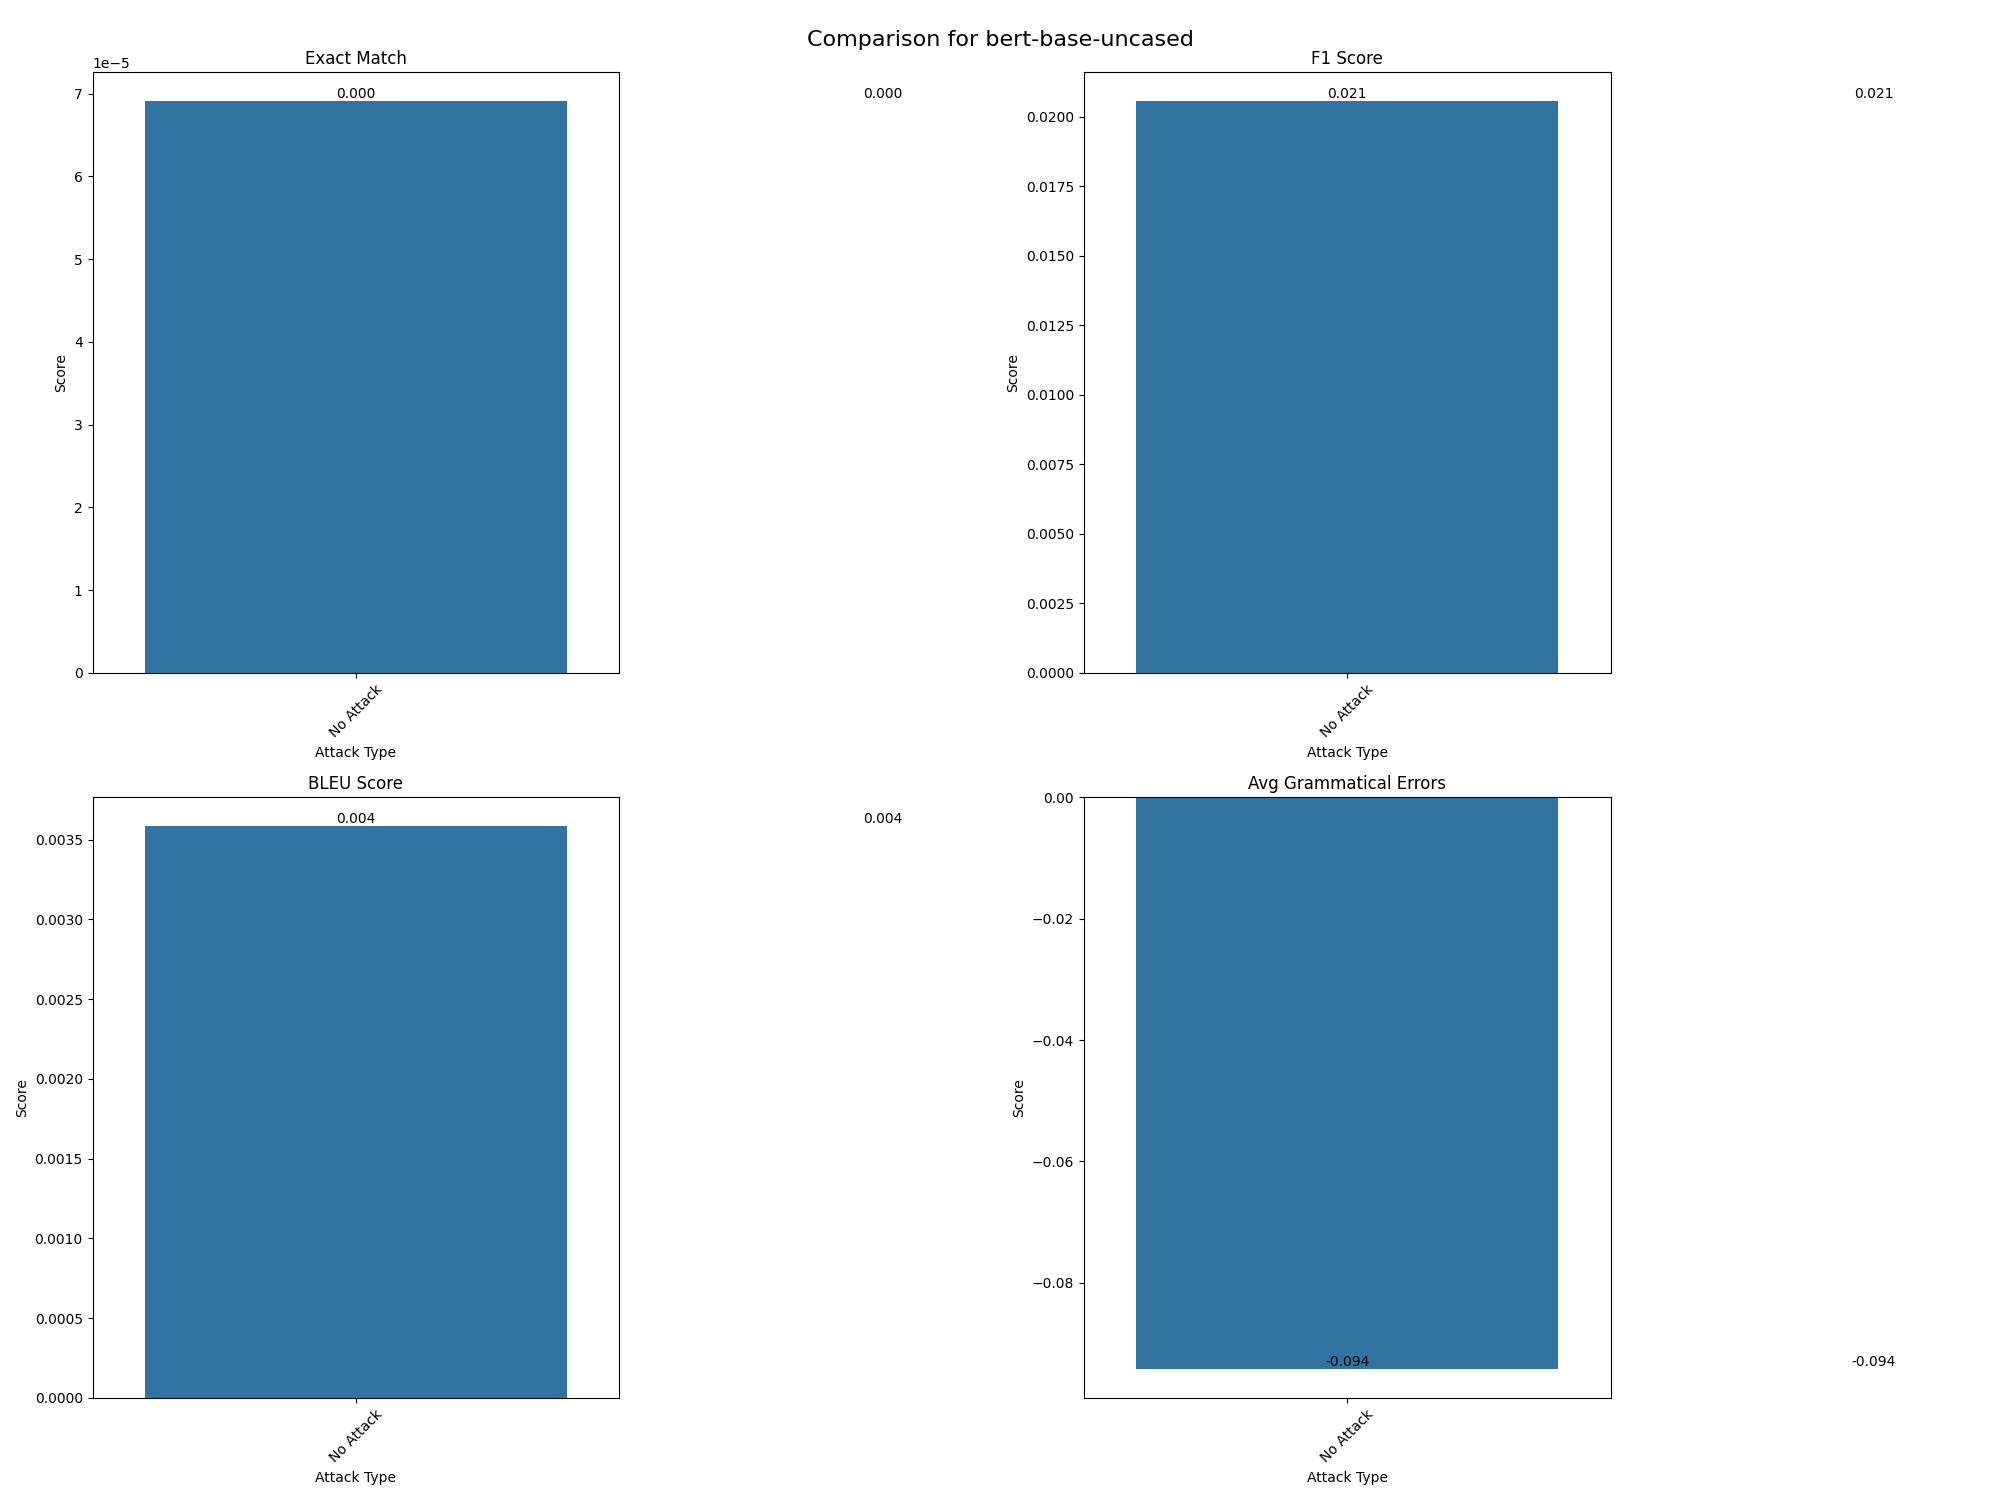

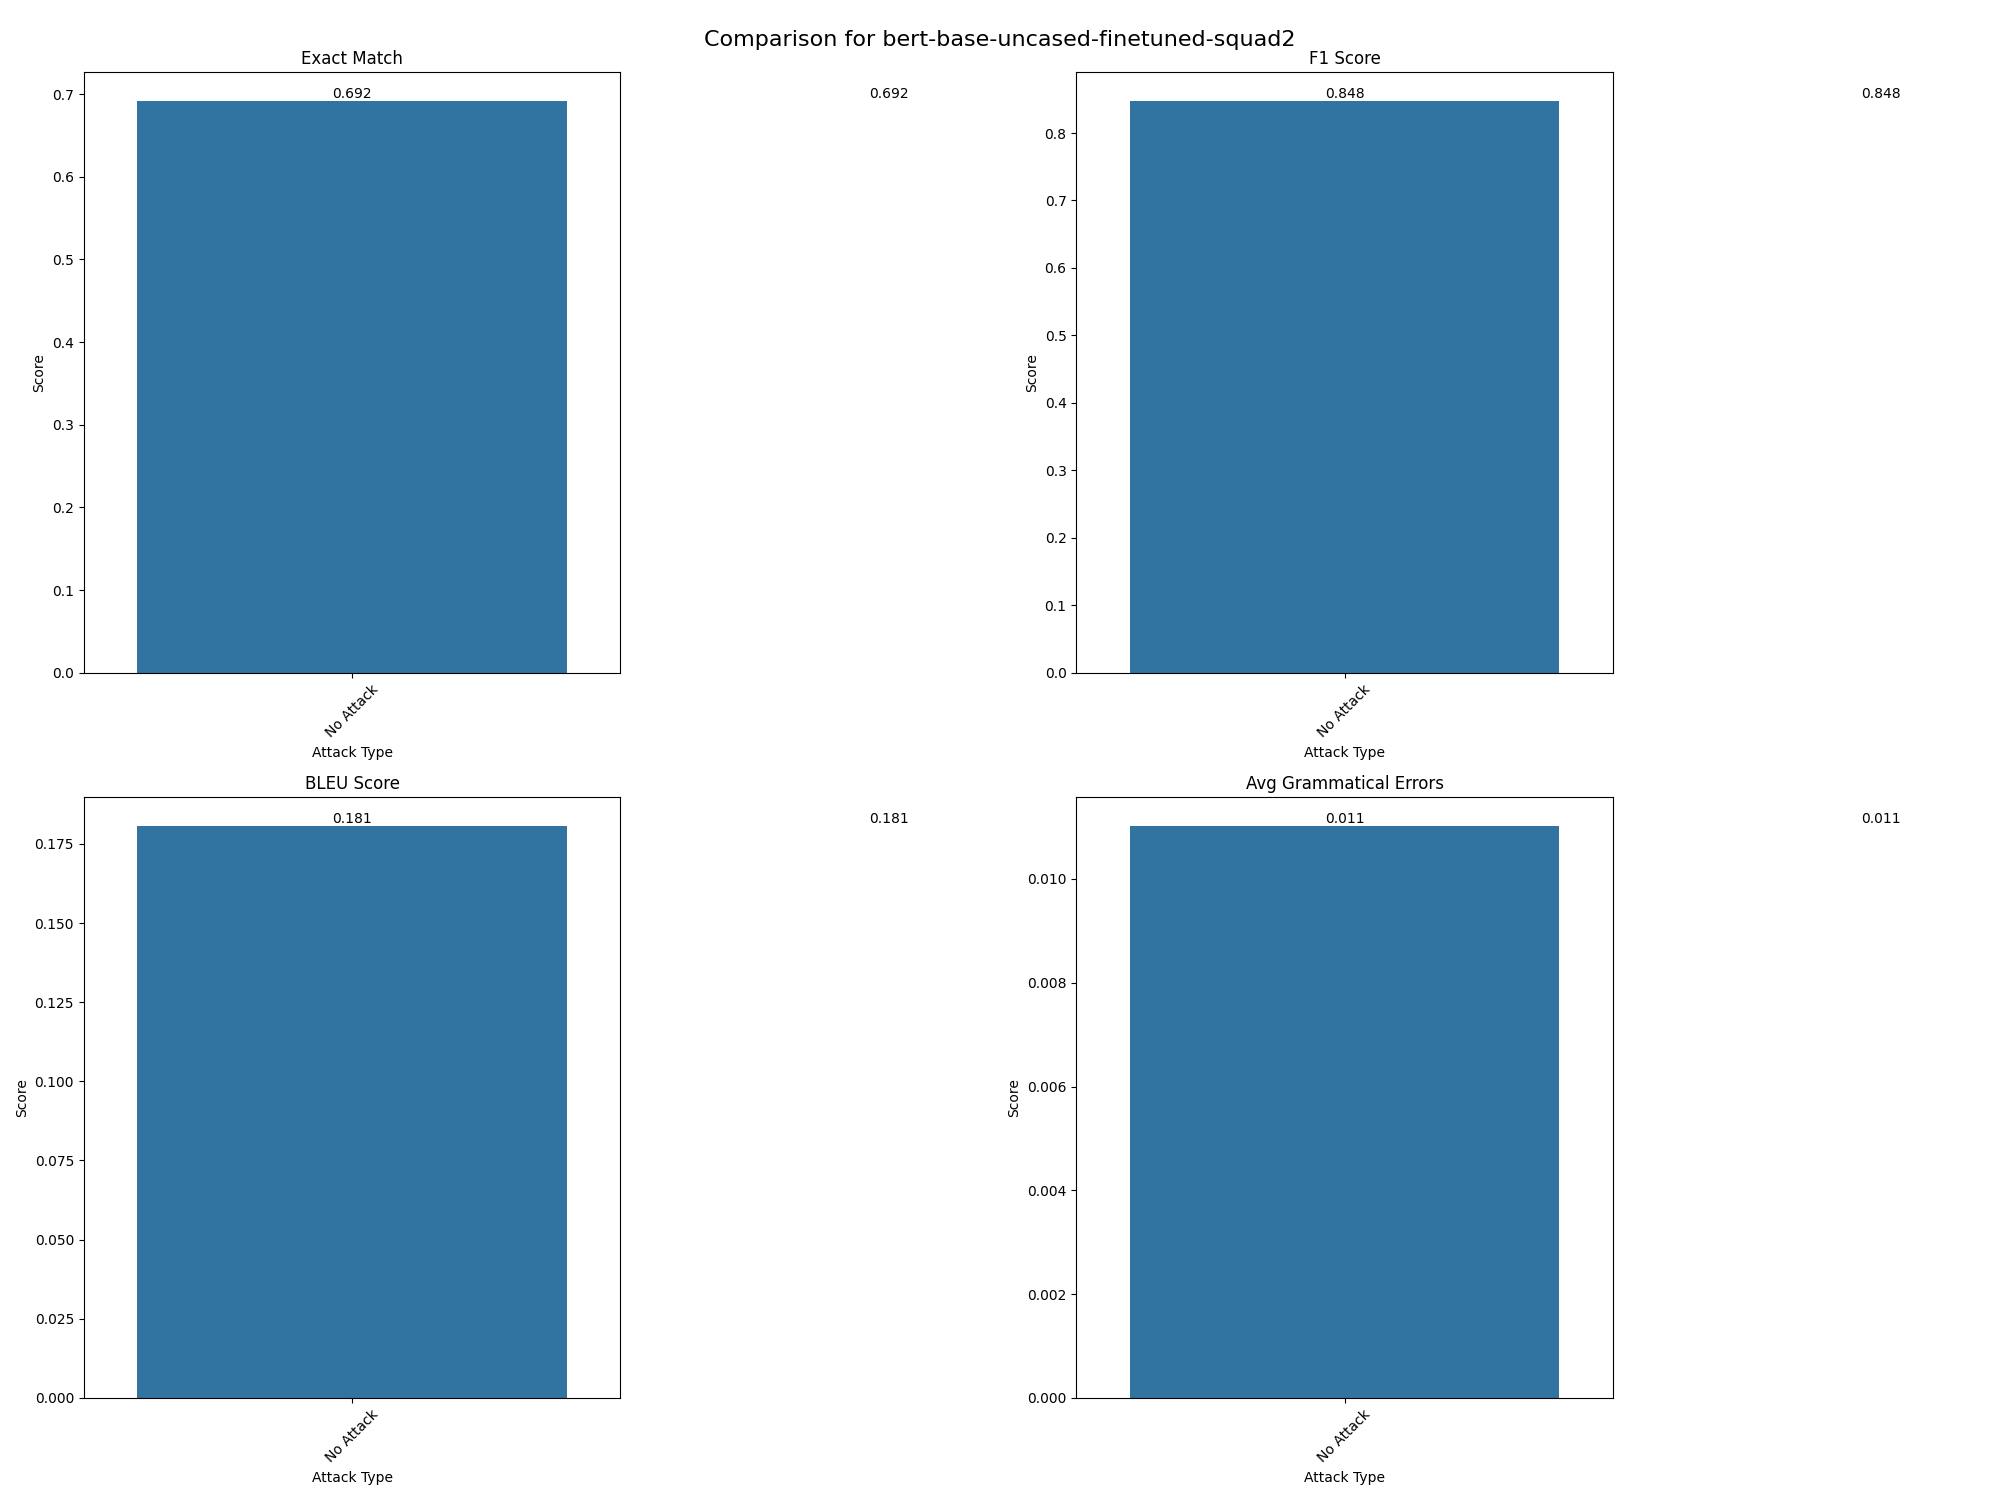

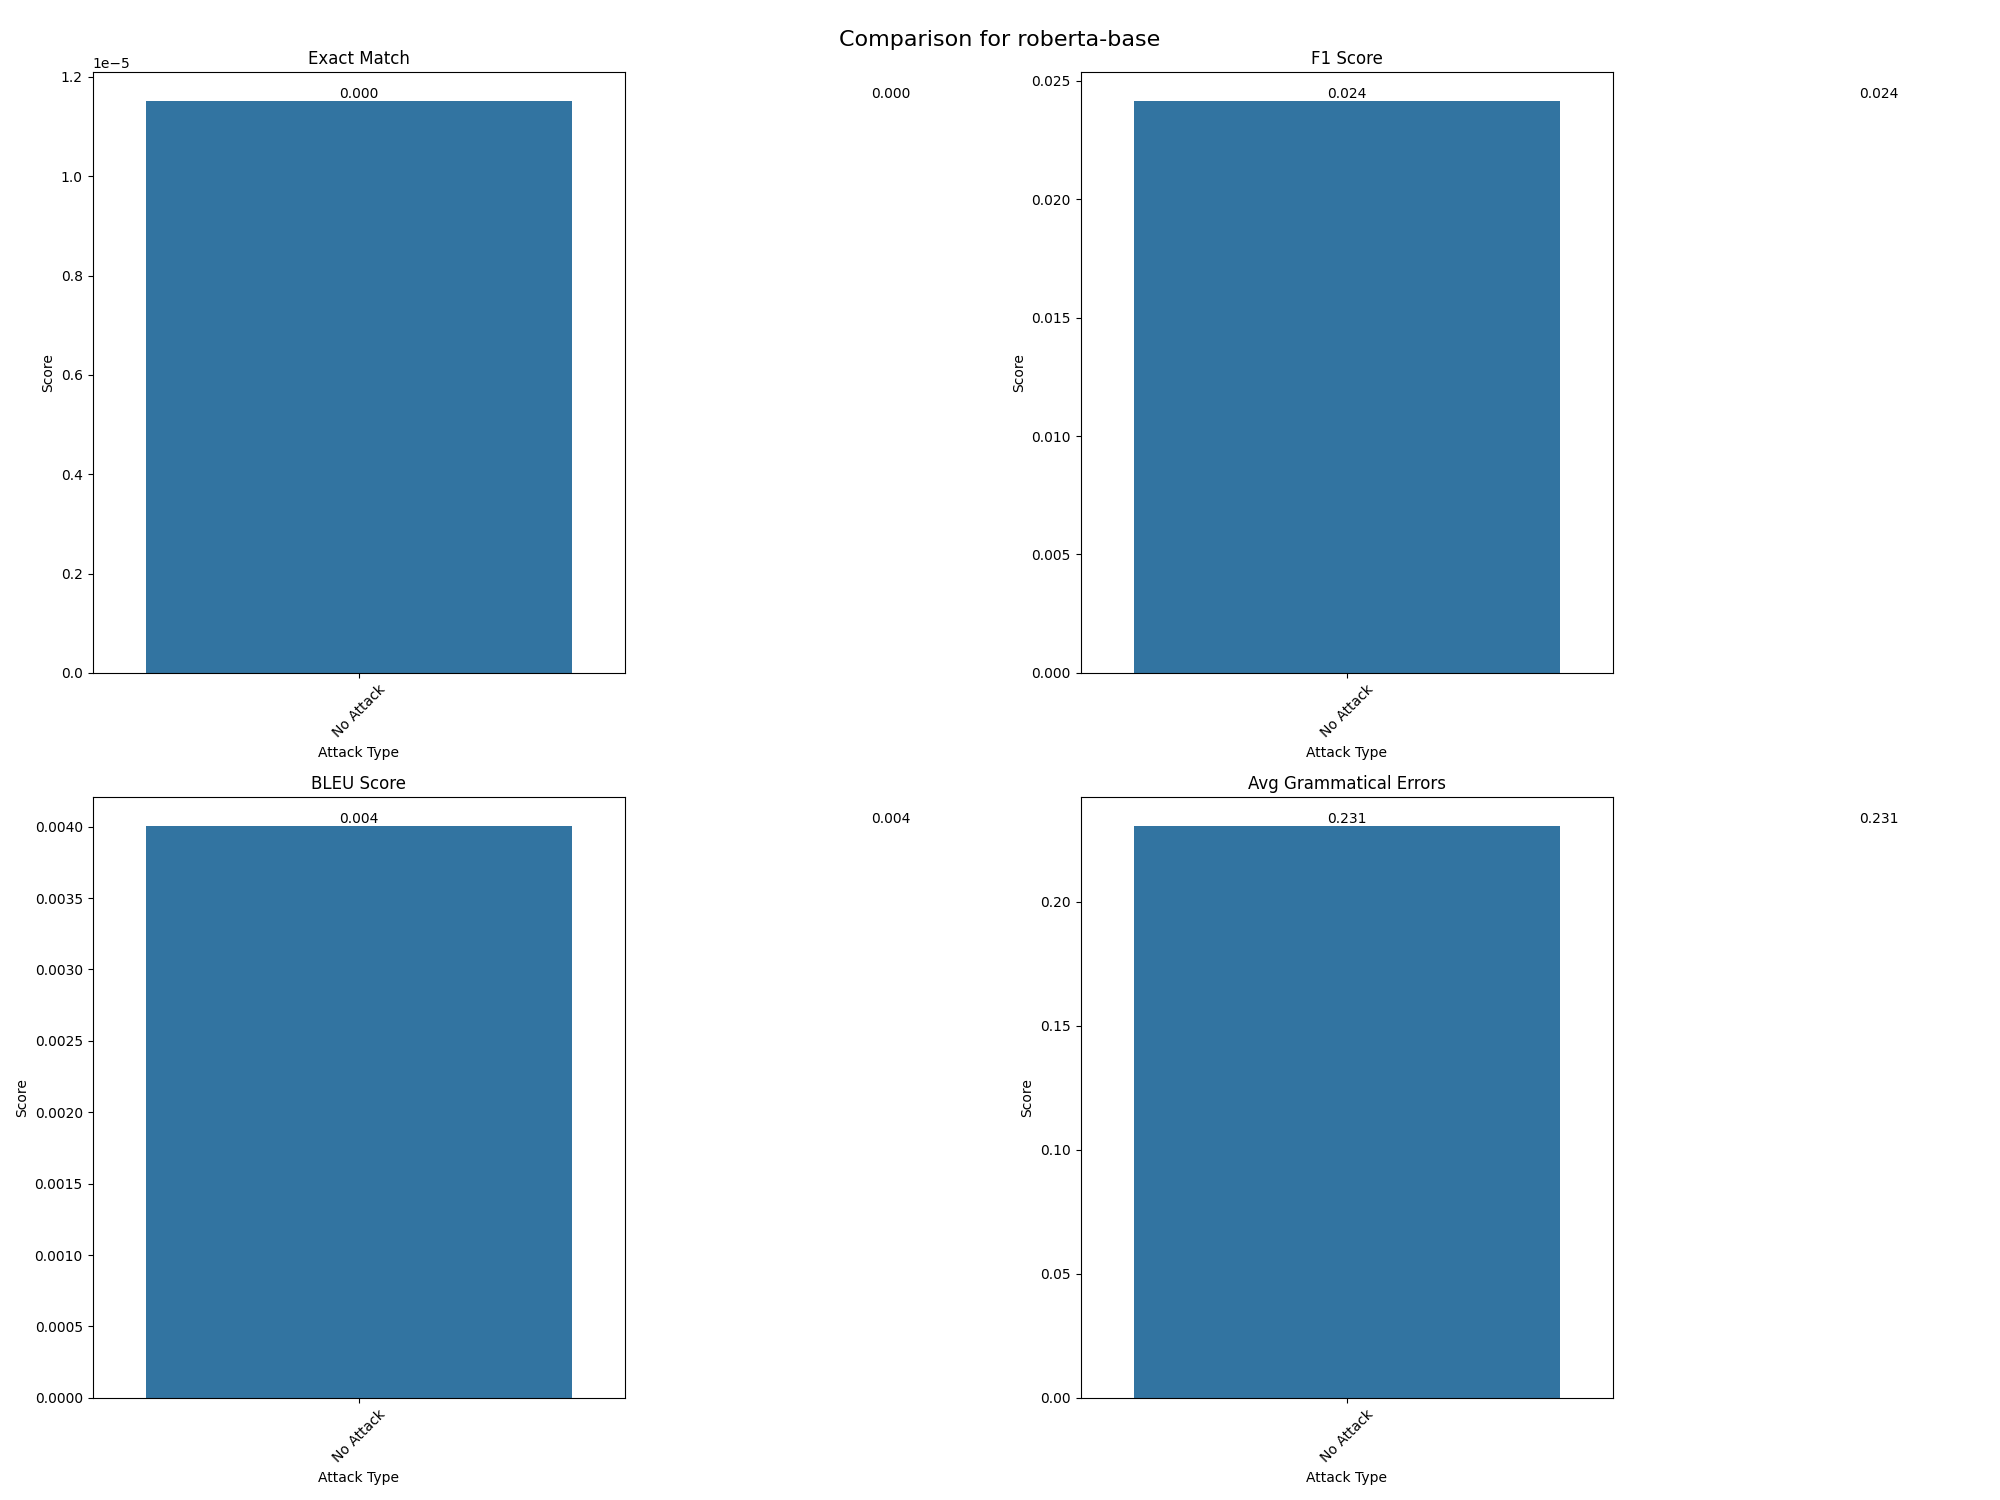

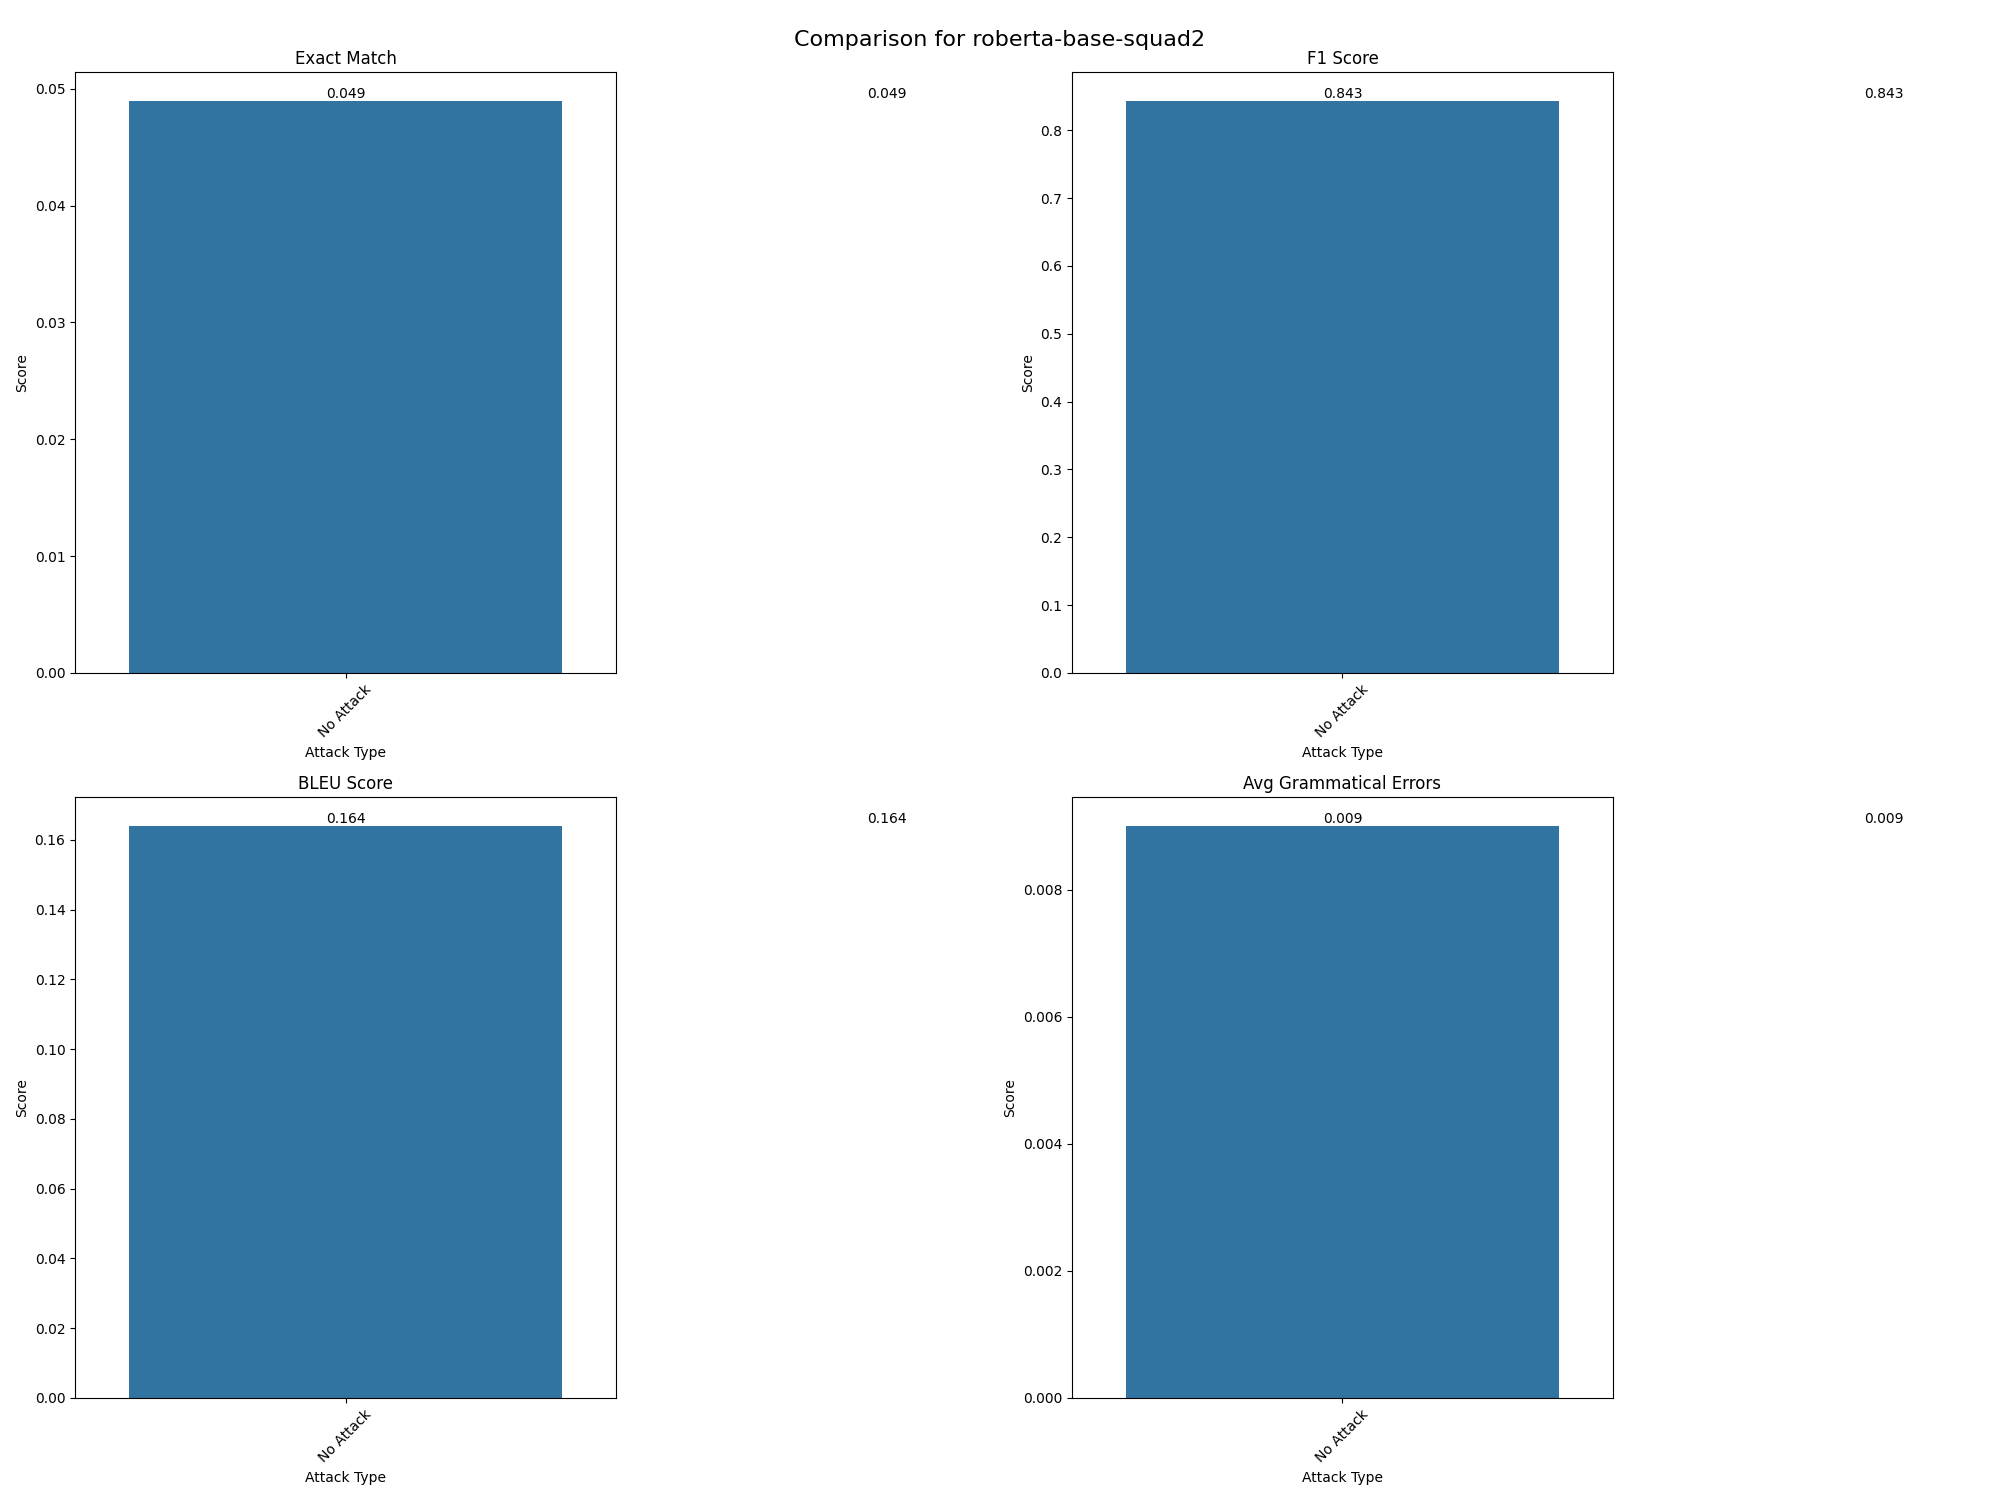

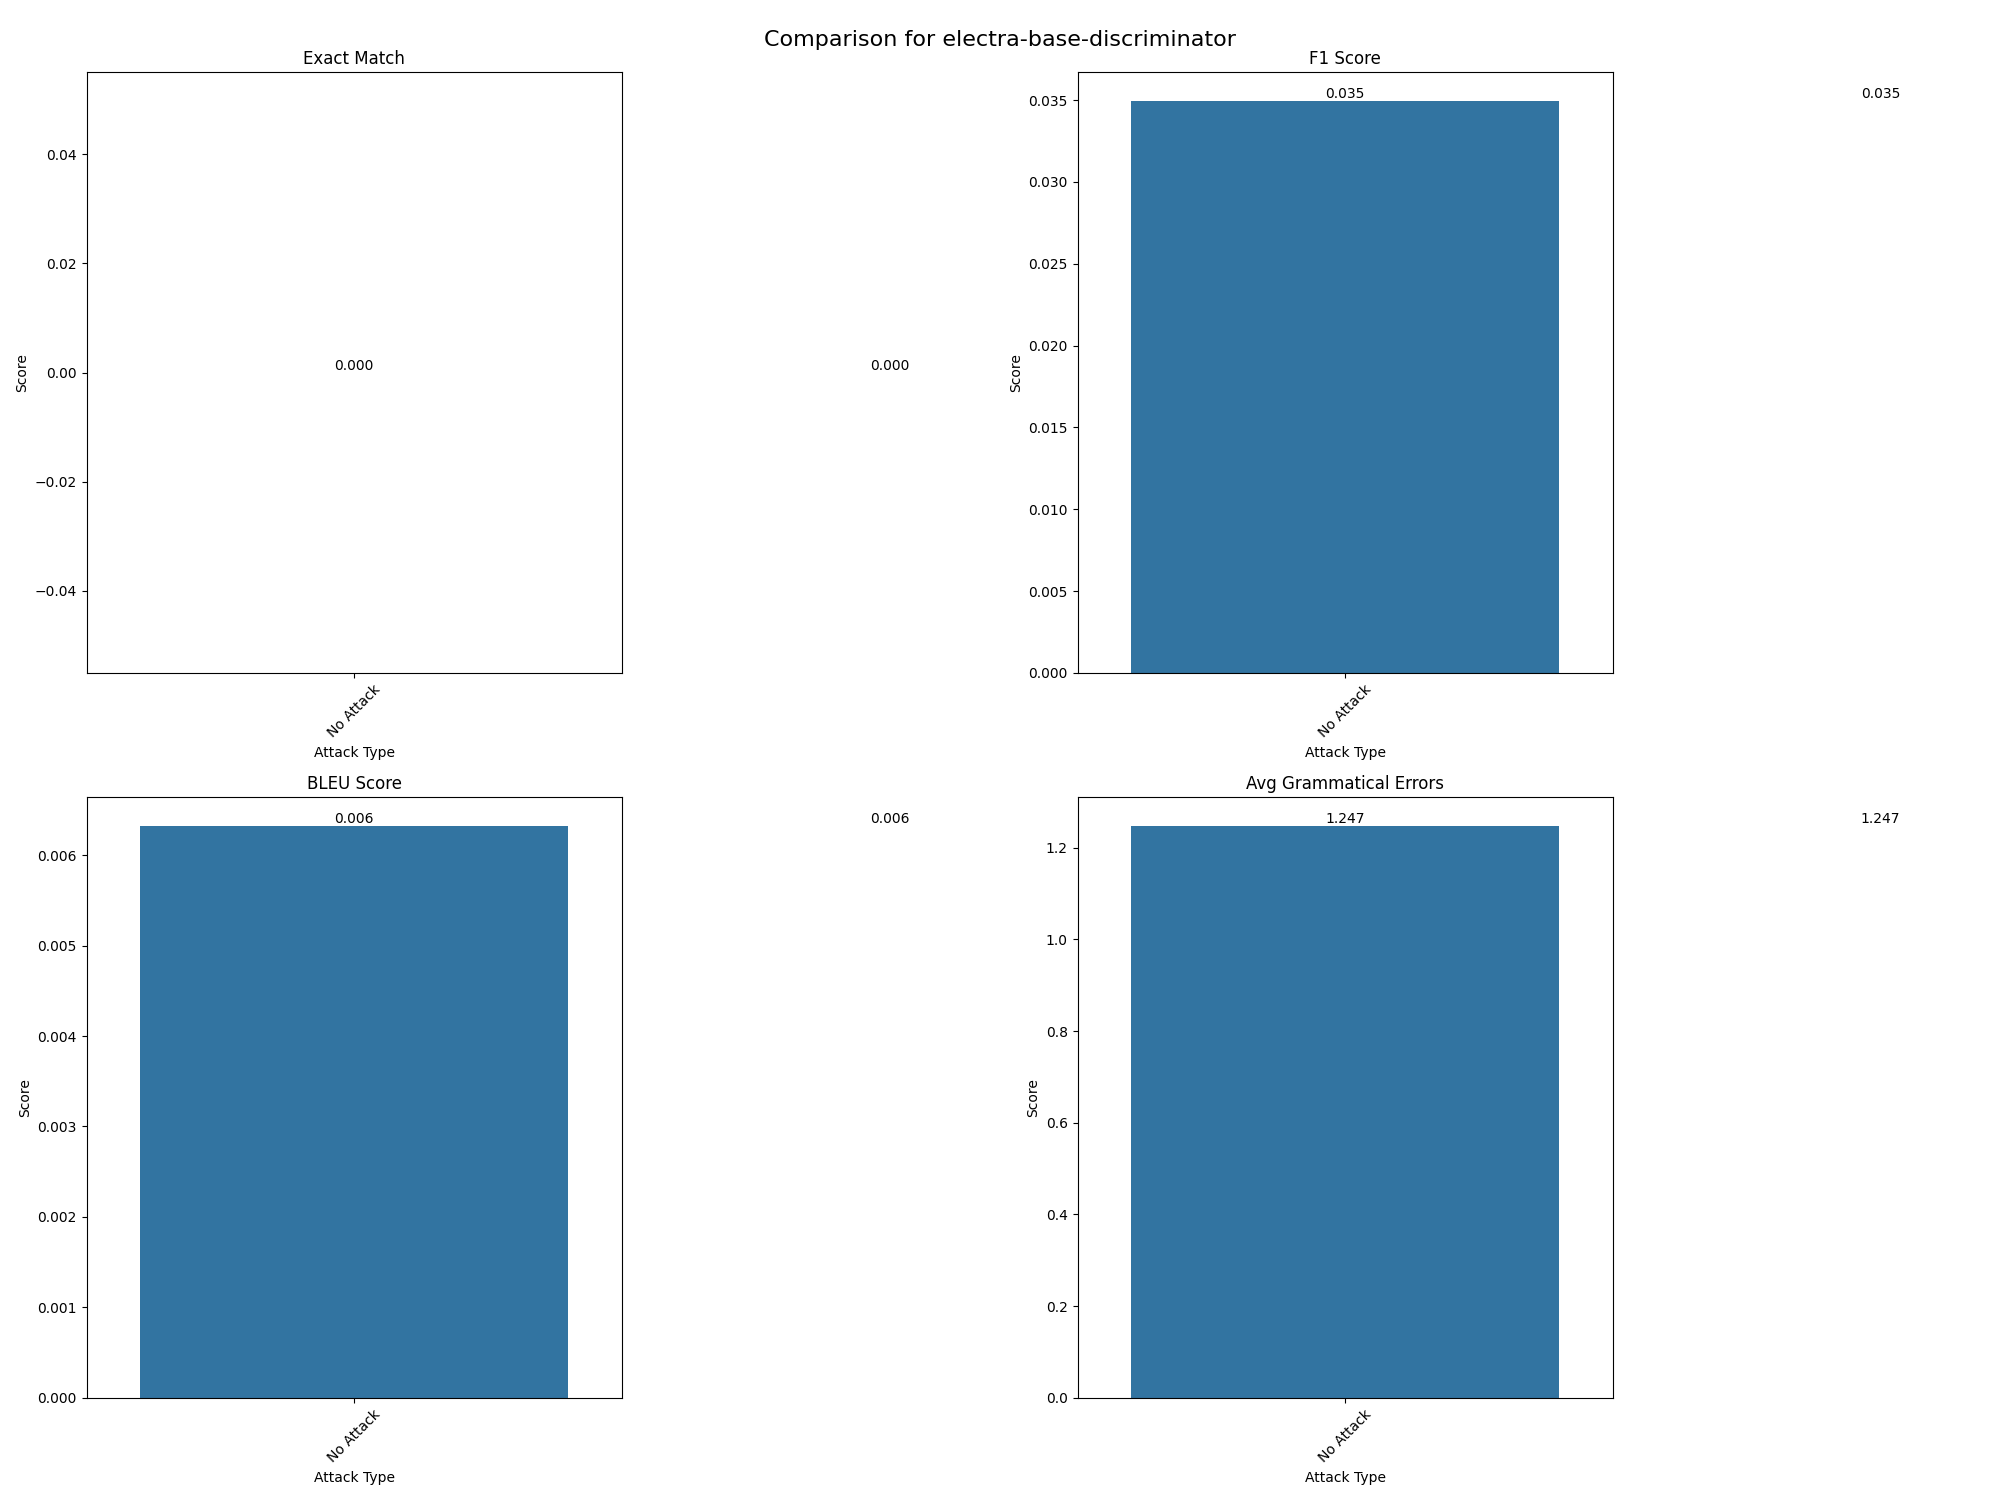

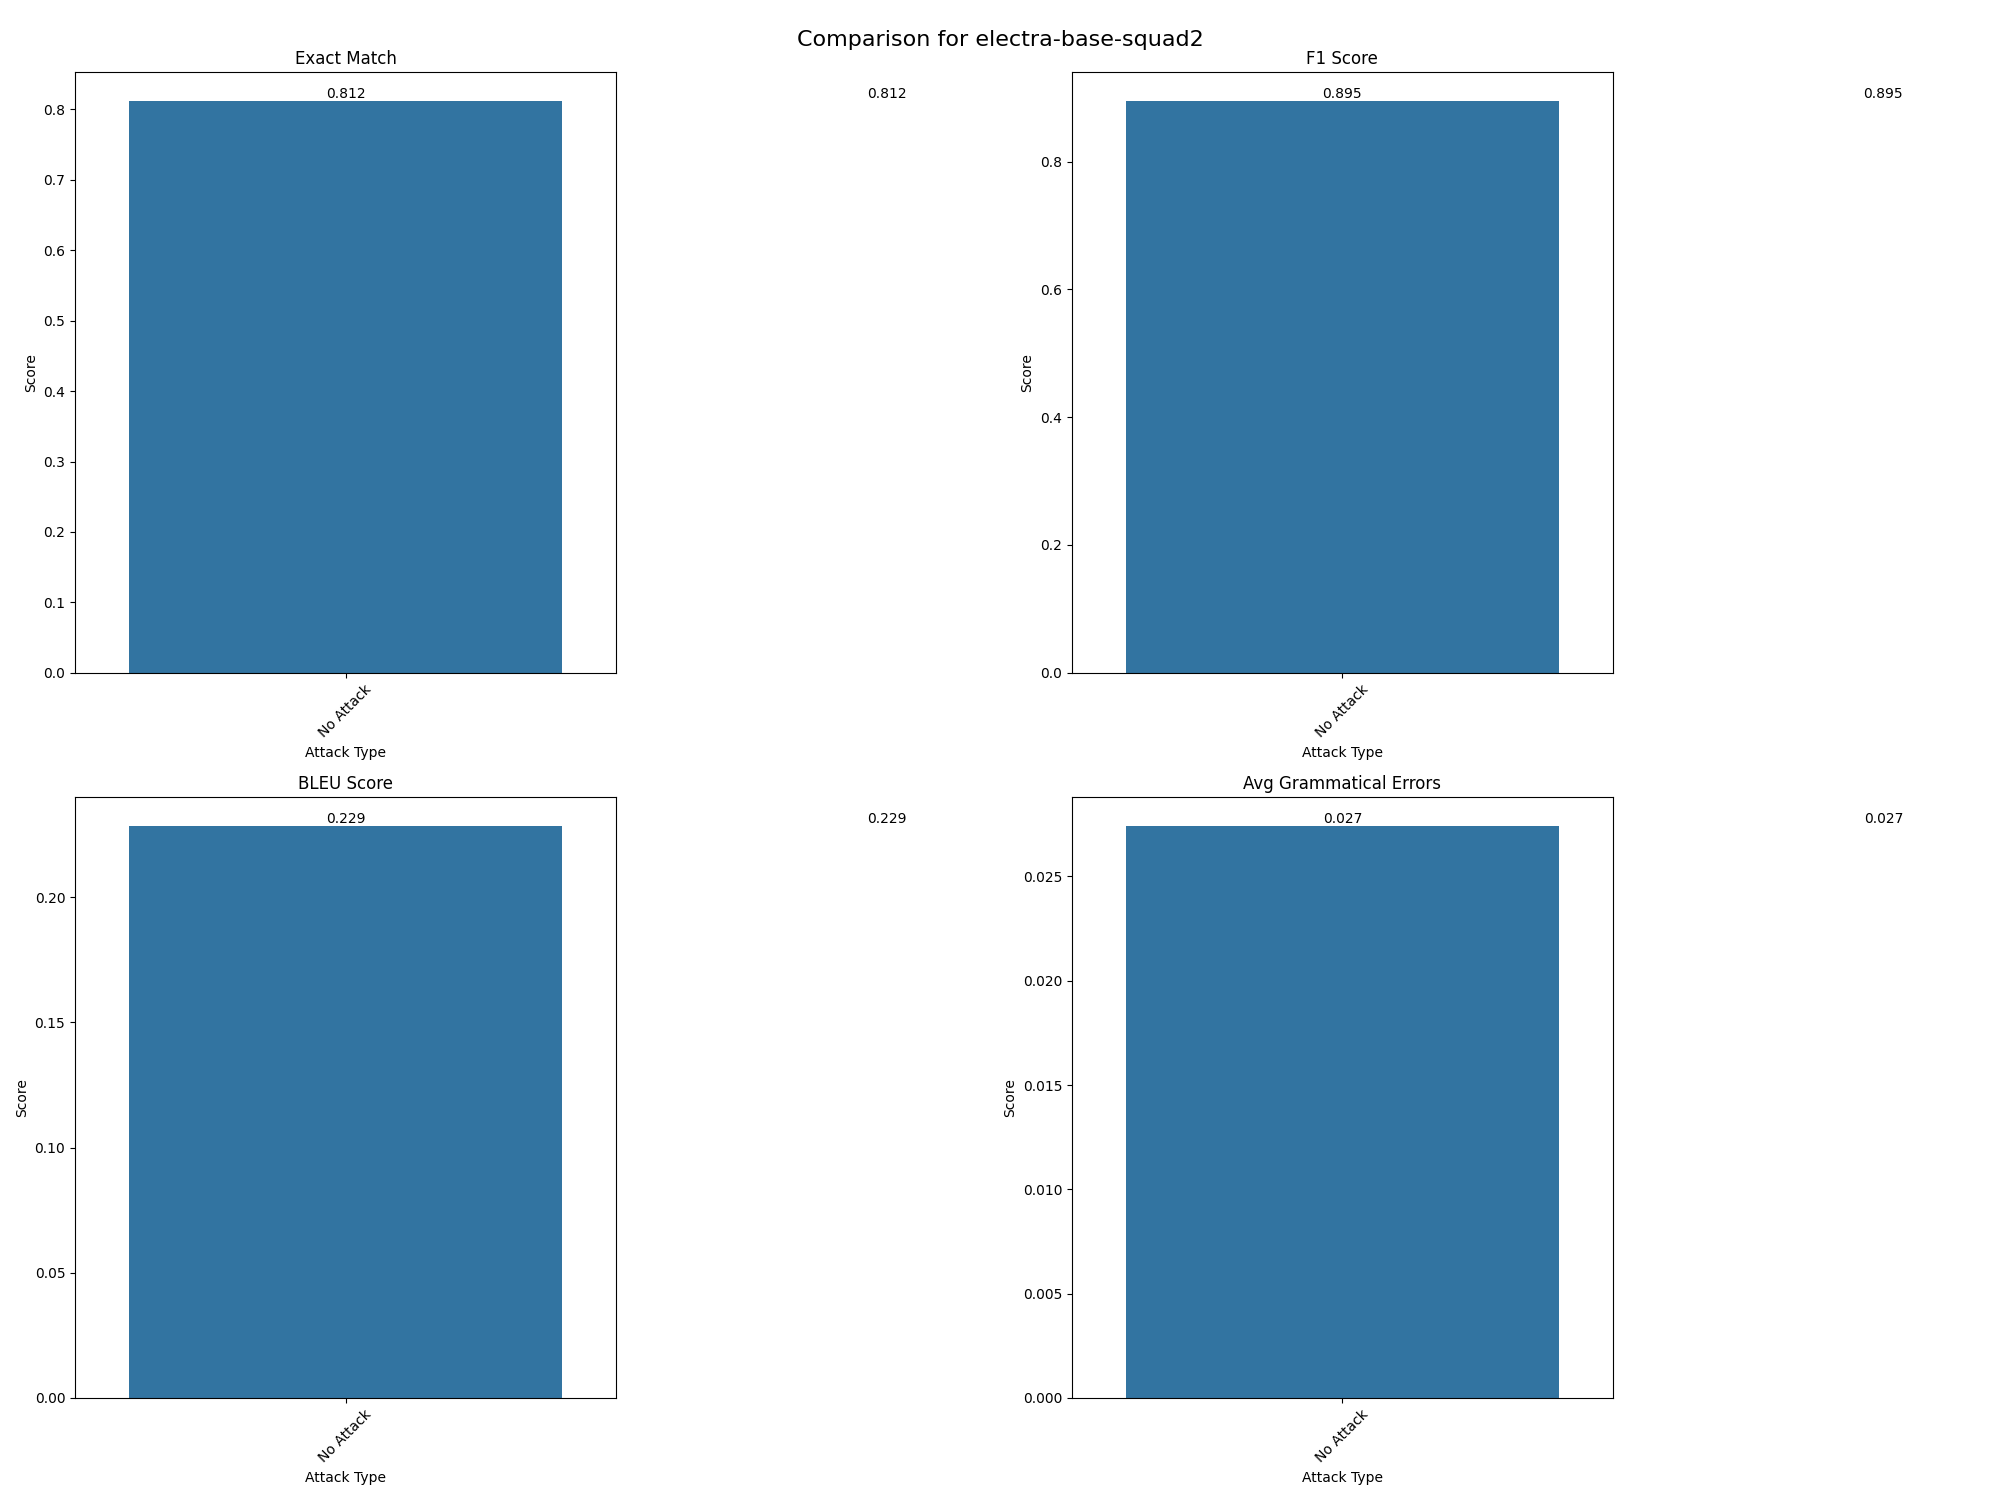

In [39]:
def visualize_comparisons(comparisons):
    metrics = ['Exact Match', 'F1 Score', 'BLEU Score', 'Avg Grammatical Errors']
    
    if not os.path.exists('images'):
        os.makedirs('images')
    
    for model_name, comparison in comparisons.items():
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        fig.suptitle(f'Comparison for {model_name}', fontsize=16)
        
        for i, metric in enumerate(metrics):
            ax = axes[i // 2, i % 2]
            
            sns.barplot(x=comparison.index, y=metric, data=comparison, ax=ax)
            
            ax.set_title(metric)
            ax.set_xlabel('Attack Type')
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)
            
            for j, v in enumerate(comparison[metric]):
                ax.text(j, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        
        image_path = os.path.join('images', f'{model_name}_baseline_comparison.png')
        plt.savefig(image_path)
        
        display(Image(filename=image_path))
        
        plt.close()

comparisons = {}
for model_name, baseline in baseline_results.items():
    model_short_name = model_name.split('/')[-1]
    attack_file = f"{model_short_name}_baseline_adversarial_attack_results.csv"
    
    try:
        attack_data = pd.read_csv(attack_file)
    except FileNotFoundError:
        print(f"Warning: {attack_file} not found. Skipping comparison for {model_name}.")
        continue
    
    baseline_summary = baseline_summaries[model_short_name]
    
    comparison = compare_baseline_to_attacks(baseline_summary, attack_data)
    comparisons[model_short_name] = comparison

visualize_comparisons(comparisons)

### Summary combination
Combines baseline and (potential) attack summaries for each model.<br />
Calculates the difference between baseline and attack performance.

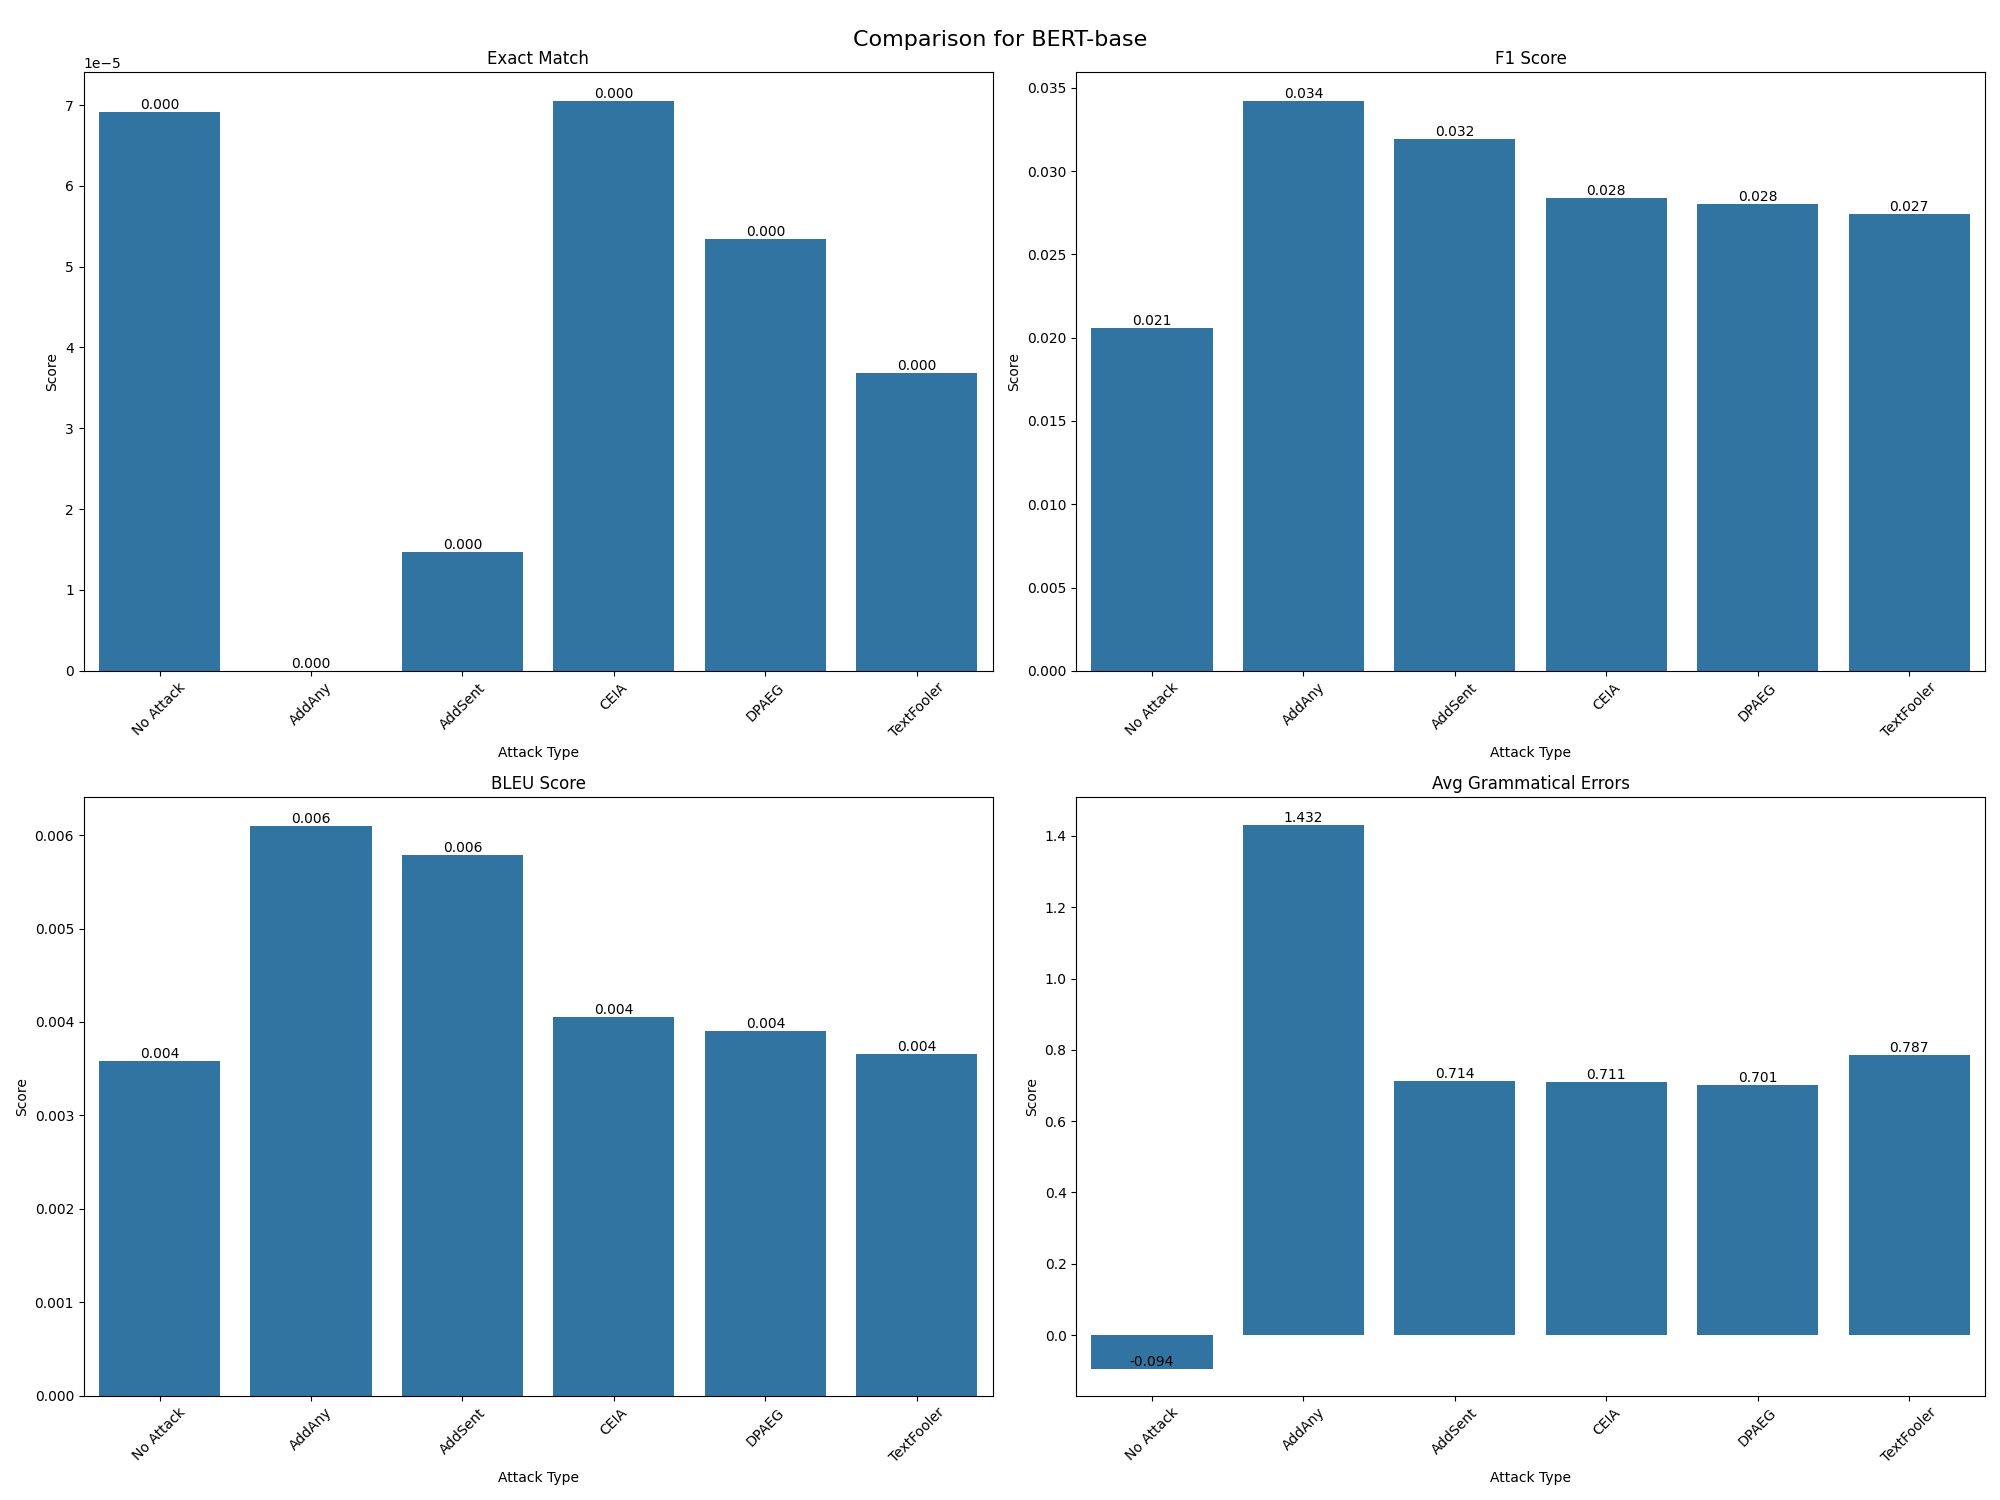

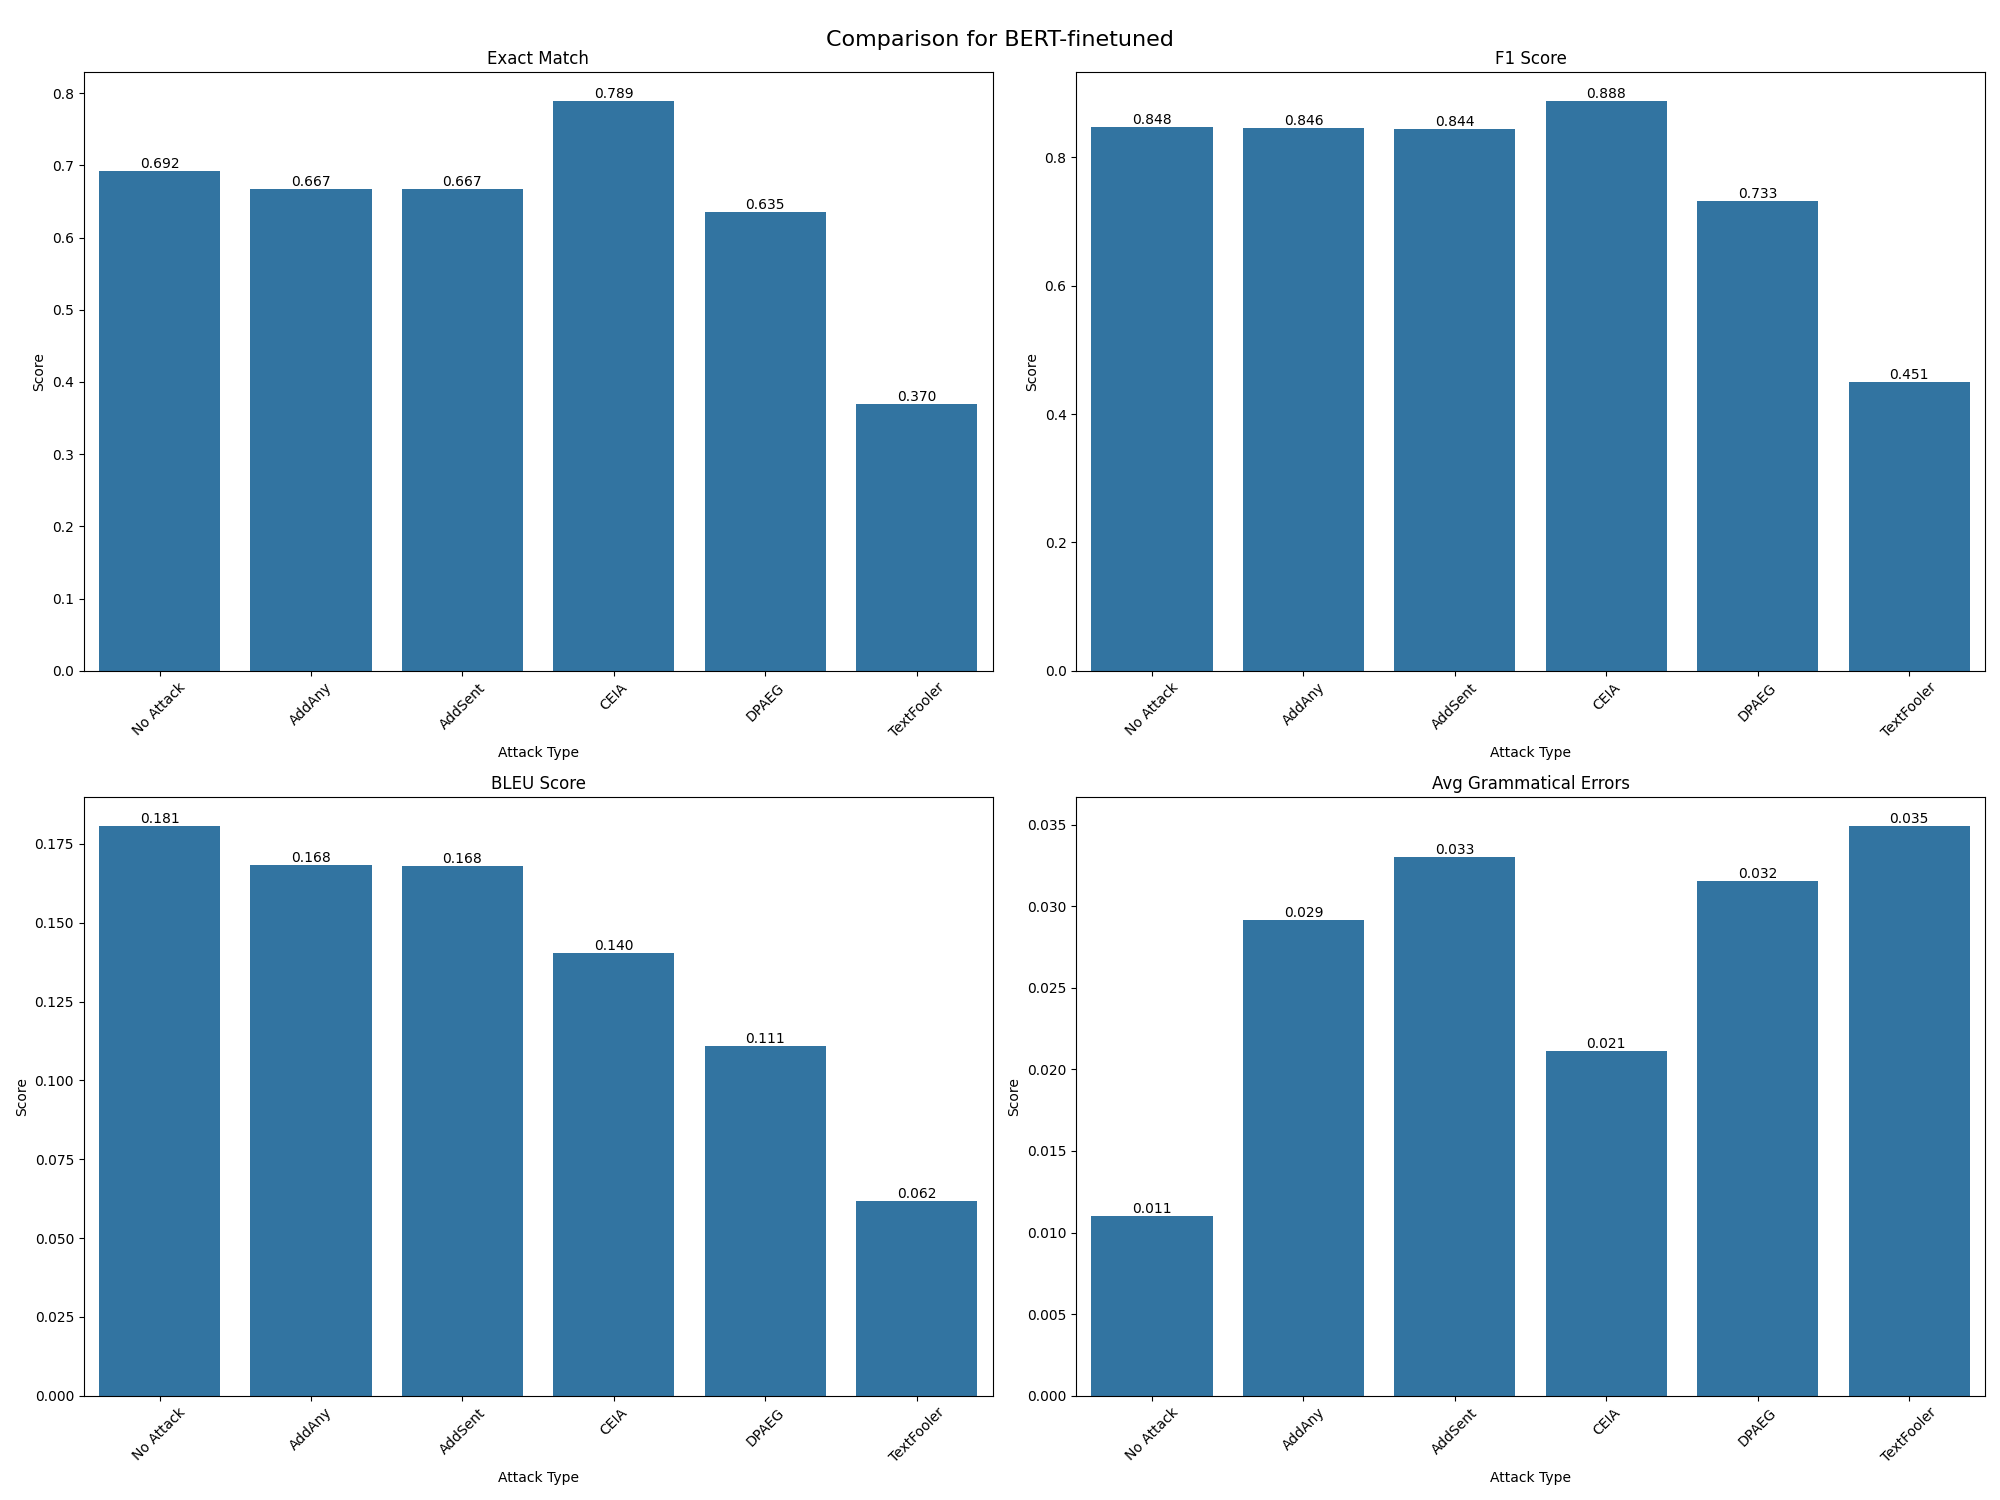

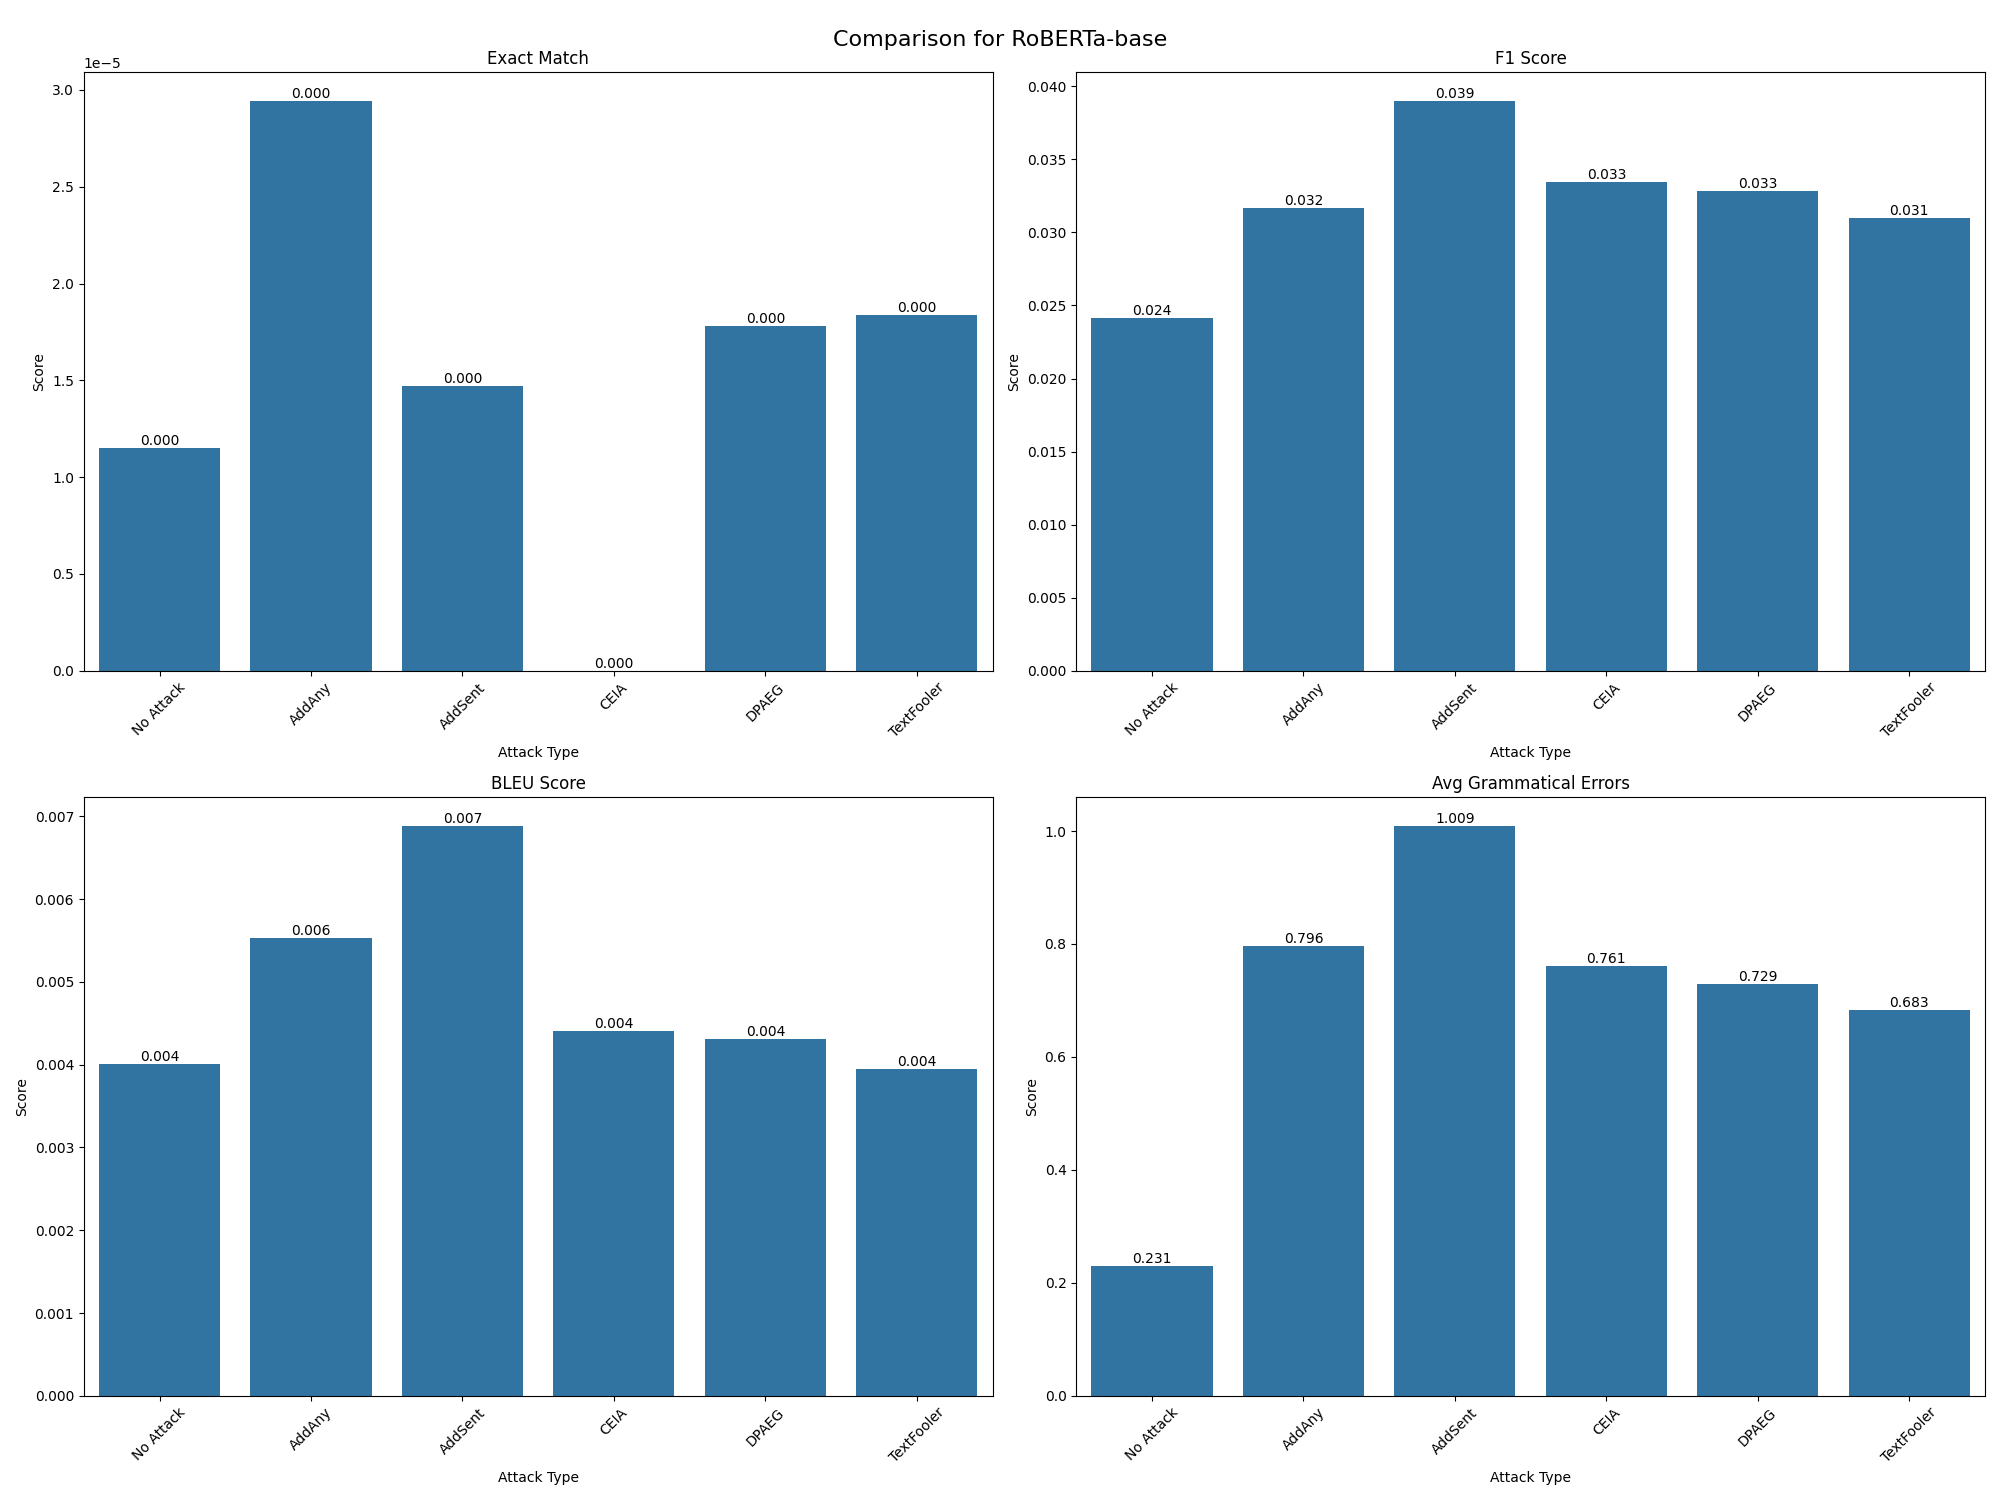

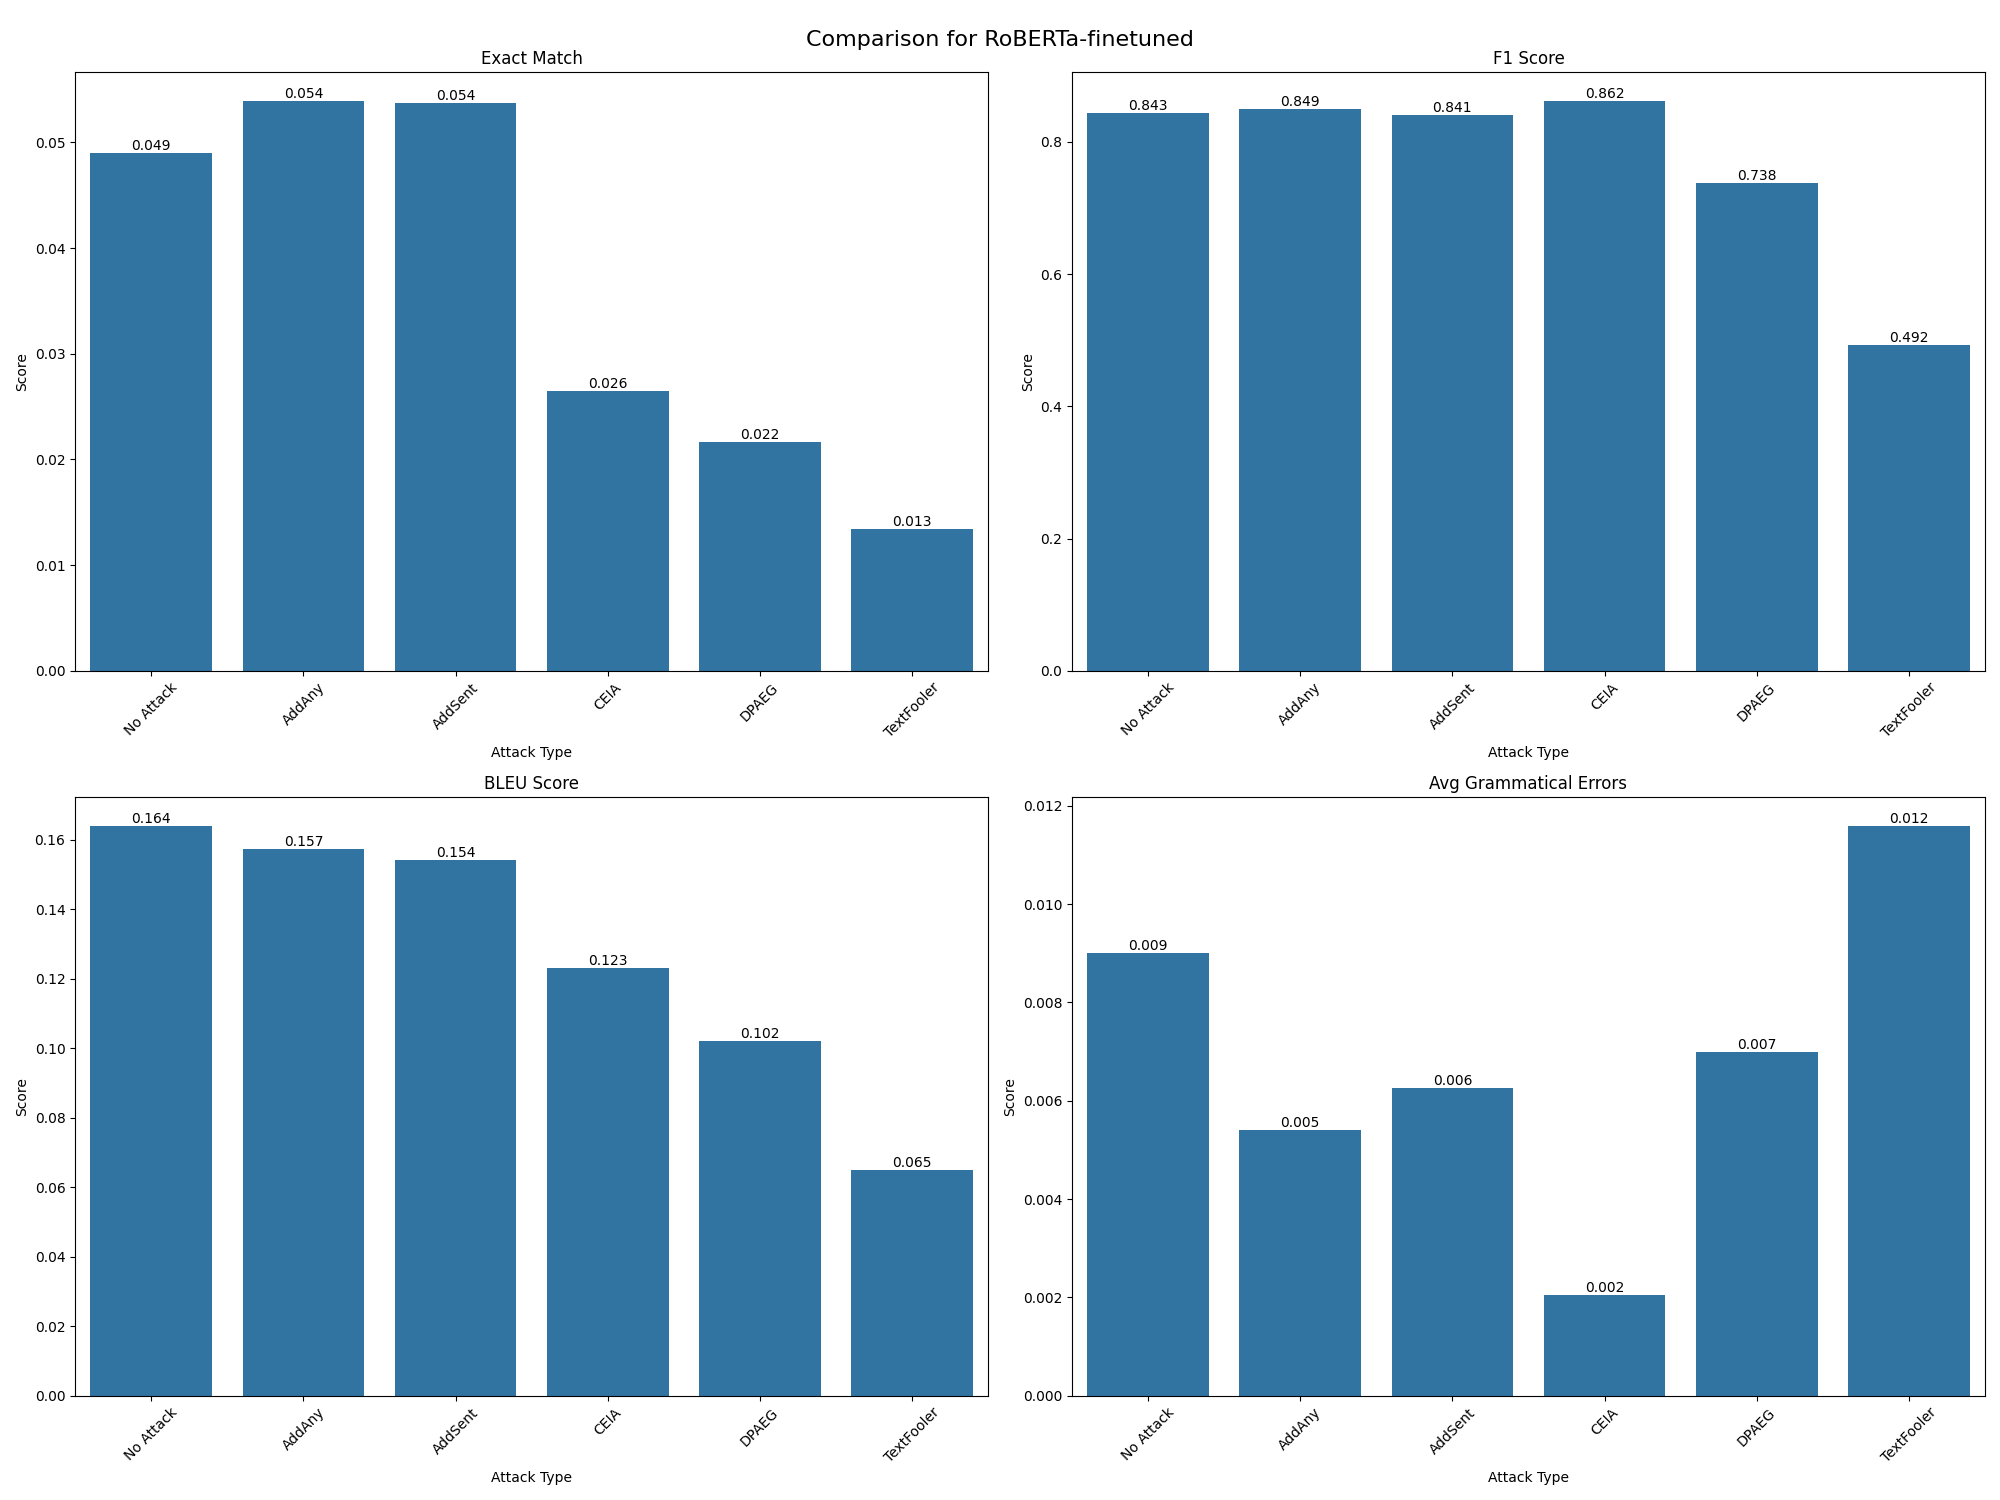

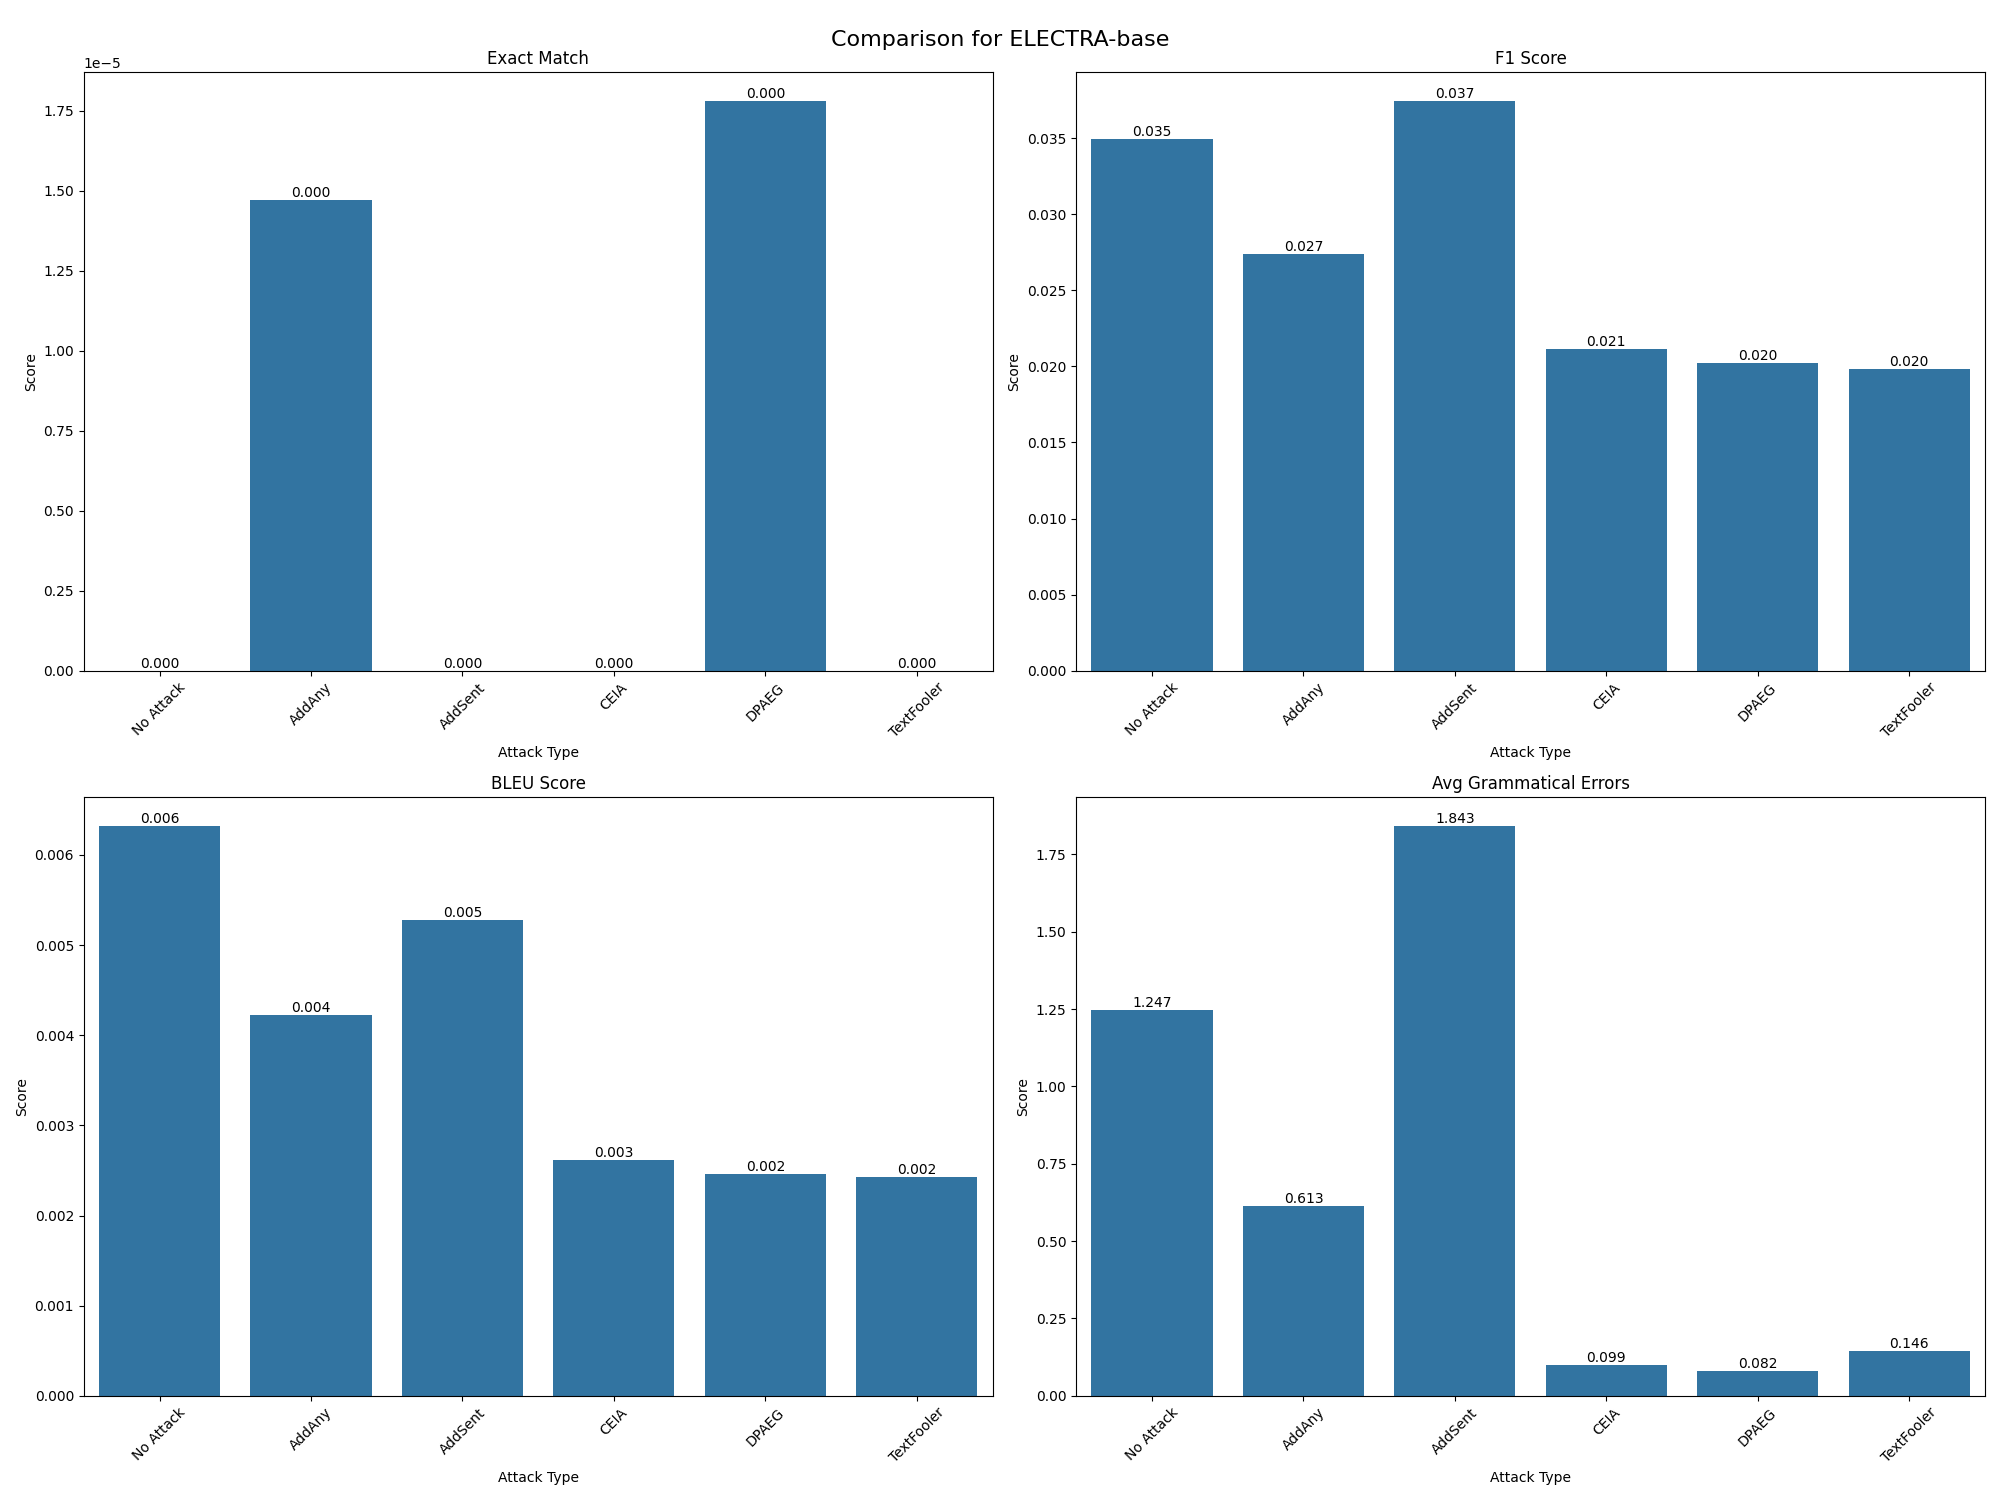

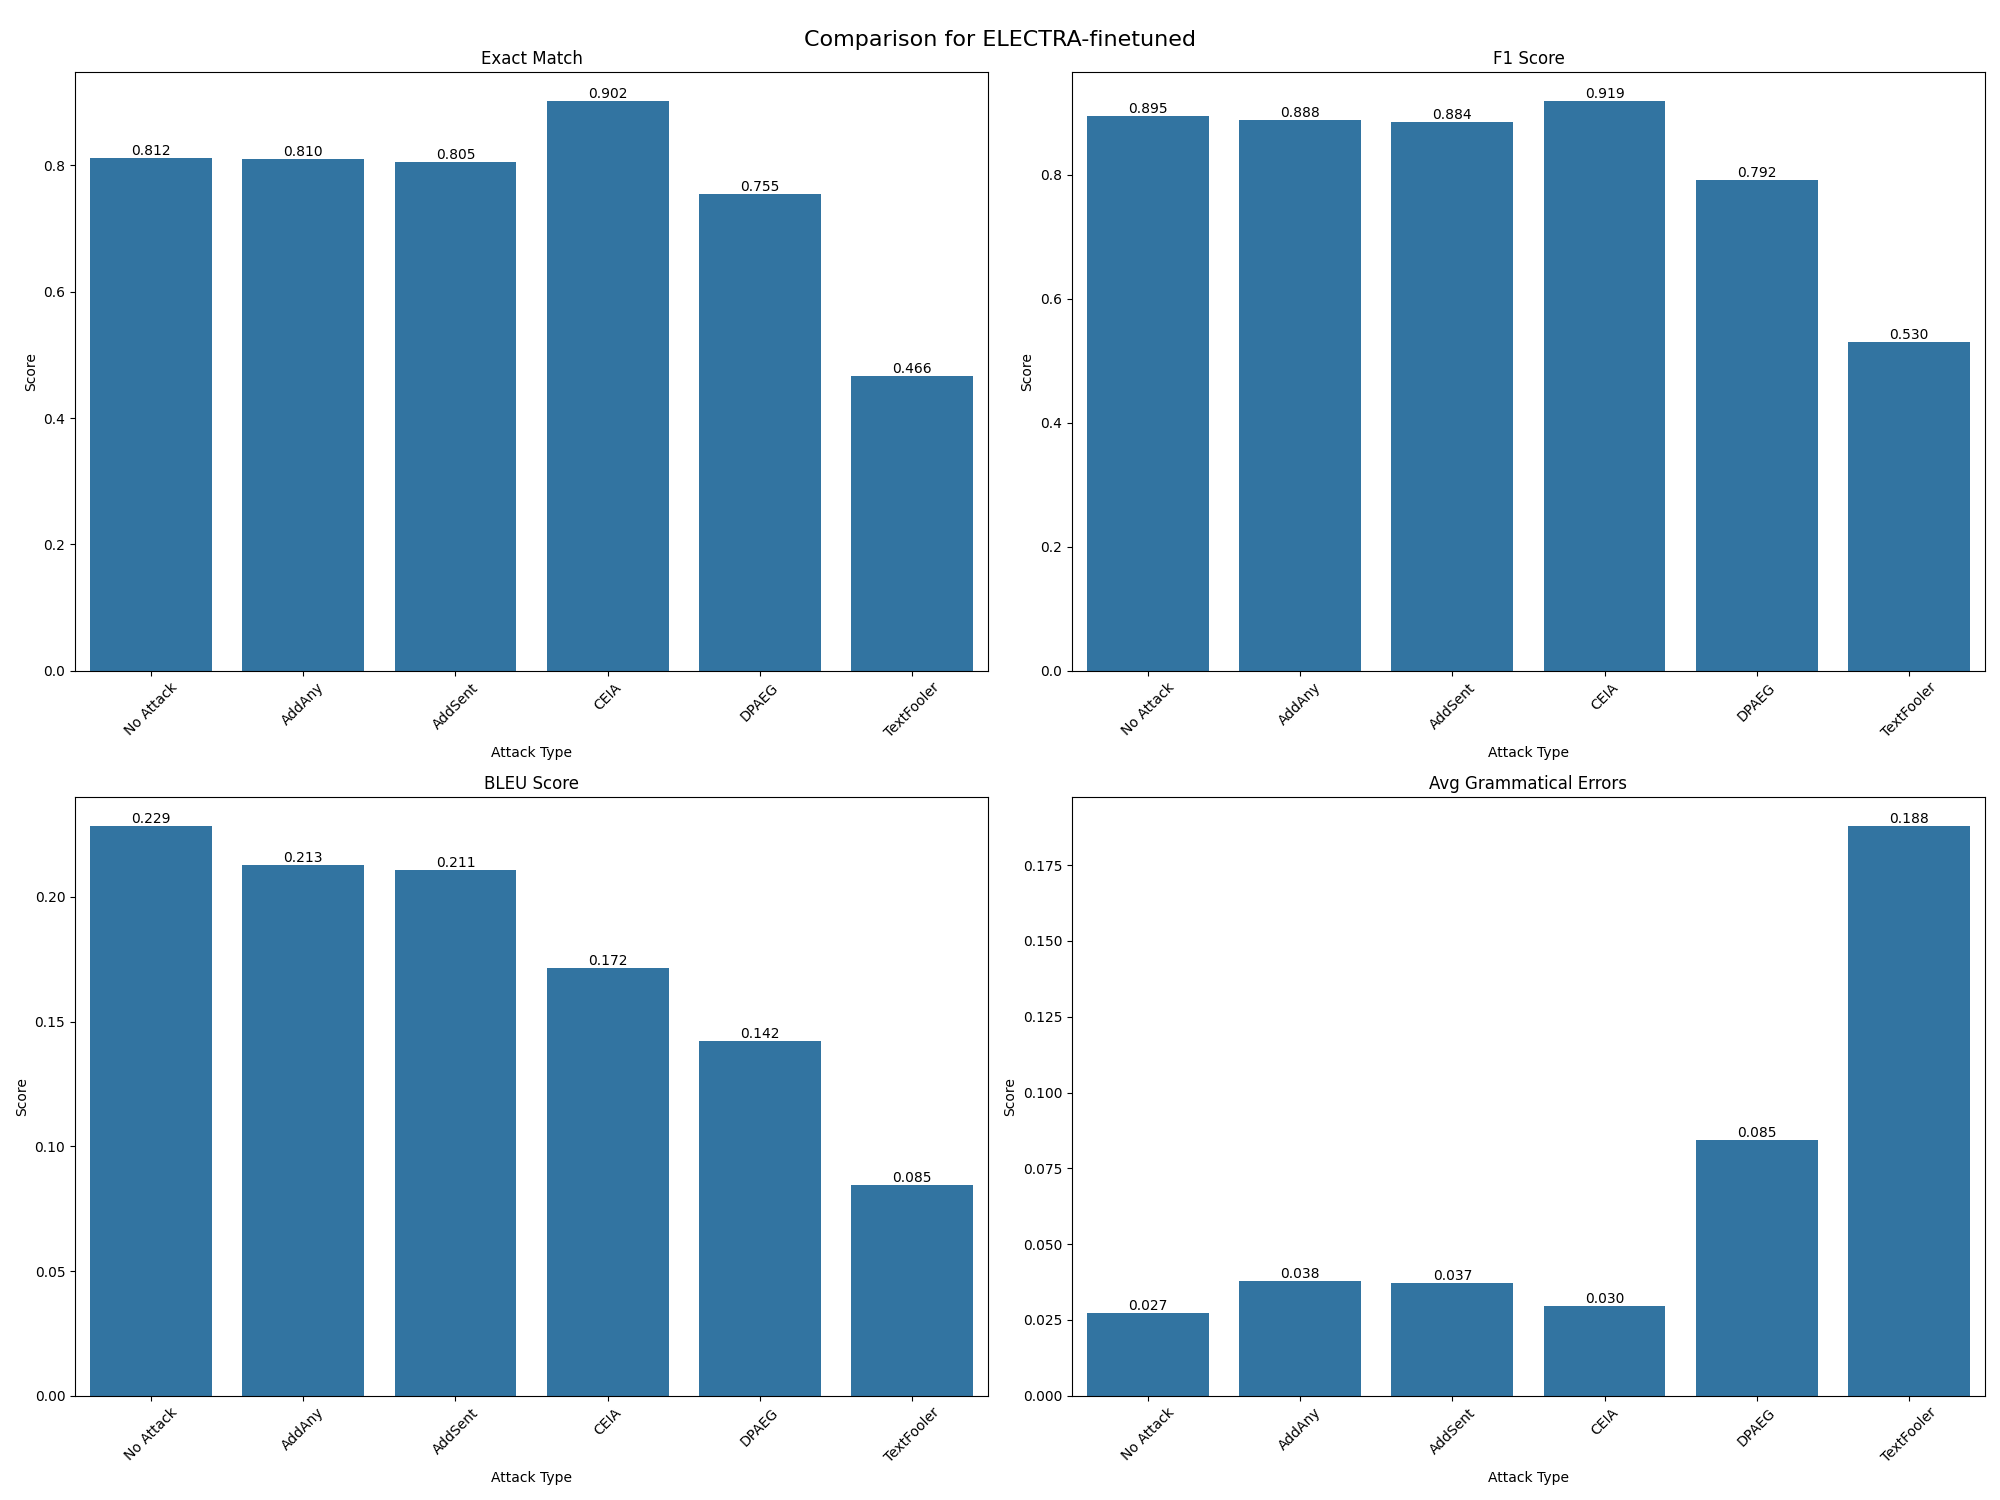

In [40]:
def compare_summaries(baseline_summary, attack_summary):
    baseline_summary = pd.DataFrame(baseline_summary) if isinstance(baseline_summary, pd.Series) else baseline_summary
    
    columns_to_compare = ['Exact Match', 'F1 Score', 'BLEU Score', 'Avg Grammatical Errors']
    
    comparison = pd.concat([baseline_summary[columns_to_compare], attack_summary[columns_to_compare]])
    
    for column in columns_to_compare:
        comparison[f'{column} Diff'] = comparison[column] - baseline_summary[column].iloc[0]
    
    return comparison

def combine_summaries():
    summary_folder = 'Results/Summary'
    models = {
        'BERT-base': ('bert-base-uncased_baseline_summary.csv', 'bert-base-uncased_adversarial_attack_summary.csv'),
        'BERT-finetuned': ('bert-base-uncased-finetuned-squad2_baseline_summary.csv', 'bert-base-uncased-finetuned-squad2_adversarial_attack_summary.csv'),
        'RoBERTa-base': ('roberta-base_baseline_summary.csv', 'roberta_adversarial_attack_summary.csv'),
        'RoBERTa-finetuned': ('roberta-base-squad2_baseline_summary.csv', 'roberta-base-squad2_adversarial_attack_summary.csv'),
        'ELECTRA-base': ('electra-base-discriminator_baseline_summary.csv', 'electra_adversarial_attack_summary.csv'),
        'ELECTRA-finetuned': ('electra-base-squad2_baseline_summary.csv', 'electra-base-squad2_adversarial_attack_summary.csv')
    }
    
    combined_summaries = {}
    
    for model_name, (baseline_file, attack_file) in models.items():
        baseline_path = os.path.join(summary_folder, baseline_file)
        attack_path = os.path.join(summary_folder, attack_file)
        
        try:
            baseline_summary = pd.read_csv(baseline_path, index_col=0)
            attack_summary = pd.read_csv(attack_path, index_col=0)
        except FileNotFoundError as e:
            print(f"Warning: {e.filename} not found. Skipping comparison for {model_name}.")
            continue
        
        comparison = compare_summaries(baseline_summary, attack_summary)
        combined_summaries[model_name] = comparison

        # Save the combined summary
        combined_csv_filename = os.path.join(summary_folder, f'{model_name}_combined_summary.csv')
        combined_summaries[model_name].to_csv(combined_csv_filename)
    
    return combined_summaries

def visualize_comparisons(comparisons):
    metrics = ['Exact Match', 'F1 Score', 'BLEU Score', 'Avg Grammatical Errors']
    
    # Create 'images' folder if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')
    
    for model_name, comparison in comparisons.items():
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        fig.suptitle(f'Comparison for {model_name}', fontsize=16)
        
        for i, metric in enumerate(metrics):
            ax = axes[i // 2, i % 2]
            
            sns.barplot(x=comparison.index, y=metric, data=comparison, ax=ax)
            
            ax.set_title(metric)
            ax.set_xlabel('Attack Type')
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)
            
            # Add value labels on the bars
            for j, v in enumerate(comparison[metric]):
                ax.text(j, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        
        # Save the figure in the 'images' folder
        image_path = os.path.join('images', f'{model_name}_comparison.png')
        plt.savefig(image_path)
        
        # Display the image
        display(Image(filename=image_path))
        
        plt.close()

# Combine summaries and generate comparisons
combined_summaries = combine_summaries()

# Visualize the comparisons
visualize_comparisons(combined_summaries)